# Setup

## Import packages

In [1]:
############################################################################################################################ 
# Get the latest CREST files for each ID within the target folder (dirname)

from pathlib import Path
import json
from sqlite3 import connect as sqlite3_connect
from sqlite3 import DatabaseError
from igraph import Graph as ig_Graph
from igraph import plot as ig_plot
from scipy.spatial.distance import cdist
from random import choice as random_choice
from itertools import combinations
from numpy import array, unravel_index, argmin, mean
import random
import numpy as np
from copy import deepcopy
import itertools
from datetime import datetime
from time import time
import neuroglancer
from webbrowser import open as wb_open
from webbrowser import open_new as wb_open_new
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm

# from eCREST_cli_beta import ecrest, import_settings
from eCREST_cli import ecrest, import_settings, get_cell_filepaths

In [2]:
def sns_joint_equal_axes(g):
    
    g.ax_joint.set_aspect('equal')
    
    # Get the position of the joint plot and marginal plots
    joint_position = g.ax_joint.get_position()
    xmarg_position = g.ax_marg_x.get_position()
    ymarg_position = g.ax_marg_y.get_position()

    # Set the position and size of the x-axis marginal plot
    g.ax_marg_x.set_position([xmarg_position.x0, joint_position.y1 + 0.02, joint_position.width, xmarg_position.height])

    # Set the position and size of the y-axis marginal plot
    g.ax_marg_y.set_position([ymarg_position.x0, joint_position.y0, ymarg_position.width, joint_position.height])
    
    return g


## Import settings

If you save a copy of settings_dict.json (found in the "under construction" directory of eCREST repo) locally somewhere outside the repo (like in your save_dir), then you can use the following code cell to import. This avoids needing to re-type the save_dir and db_path each time you "git pull" updates from the repo to this notebook.

In [3]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

vx_sizes = [16,16,30]

# Load files

## mg_network file names

In [4]:
dirpath = Path(settings_dict['save_dir'])


In [5]:
nodefiles = get_cell_filepaths(dirpath)

## df_syn pre or post

In [57]:
df_syn = pd.read_csv(dirpath / 'graphs/df_postsyn.csv')
syn = 'post-synaptic'

In [58]:
df_syn.loc[df_syn['post_type'].isin(['dml']),'post_type']='mli'

df_syn.loc[df_syn['pre_type'].isin(['dml']),'pre_type']='mli'

In [109]:
if syn == 'pre-synaptic':
    df_syn.drop(df_syn[df_syn['pre'].isin([299392199,386392158,472361842,389085521,227254070,228321391,403522169,313068329,126649726])].index, inplace=True)

In [183]:
# df_syn.loc[df_syn['pre']==285761792,'pre_type']='pe'

### --> df_edges

In [59]:
# remove structure and soma diameter information if want to
df_syn = df_syn.drop(['Unnamed: 0','x','y','z','structure'],axis=1)#,'pre_diam','post_diam','diam_diff'],axis=1) # 

df_edges=df_syn.value_counts().reset_index(name='weight')

In [60]:
df_edges.loc[:,'post_type'] = [t.lower() for t in df_edges['post_type']]
df_edges.loc[:,'pre_type'] = [t.lower() for t in df_edges['pre_type']]

In [61]:
df_edges.head(4)

,pre,post,pre_type,post_type,weight
0,130781211,215526370,sg2,lg,32
1,306461085,301863996,sg2,lg,32
2,473631846,305332461,mg2,lg,30
3,41579854,393078033,mg1,lf,29


## Combined df_syn

In [470]:
df_post = pd.read_csv(dirpath / 'graphs/df_postsyn.csv')
df_pre = pd.read_csv(dirpath / 'graphs/df_presyn.csv')



In [471]:
df_pre.loc[df_pre['post_type'].isin(['dml']),'post_type']='mli'
df_pre.loc[df_pre['pre_type'].isin(['dml']),'pre_type']='mli'
df_post.loc[df_post['post_type'].isin(['dml']),'post_type']='mli'
df_post.loc[df_post['pre_type'].isin(['dml']),'pre_type']='mli'

In [472]:
df_pre = df_pre.rename(columns={'pre':'post','post':'pre','pre_type':'post_type','post_type':'pre_type'})

## --> df_edges

In [473]:
df_edges_pre=df_pre.drop(['Unnamed: 0','x','y','z','structure'],axis=1).value_counts().reset_index(name='weight')

df_edges_post=df_post.drop(['Unnamed: 0','x','y','z','structure'],axis=1).value_counts().reset_index(name='weight')

In [474]:
df_edges = deepcopy(df_edges_post)

## if want to keep any information that might differ between the two dataframes, use the following code first to rename columns in df_edges_pre to match df_edges
# df_edges_pre = df_edges_pre.rename(columns={'pre_type': 'pre_type_x', 'post_type': 'post_type_x', 'weight': 'weight_x'})

# Than use combine_first to merge the DataFrames
df_edges = df_edges_post.set_index(['pre', 'post']).combine_first(df_edges_pre.set_index(['pre', 'post'])).reset_index()

In [475]:
df_edges.loc[:,'post_type'] = [t.lower() for t in df_edges['post_type']]
df_edges.loc[:,'pre_type'] = [t.lower() for t in df_edges['pre_type']]

In [476]:
# Display the final DataFrame
df_edges.head(4)

,pre,post,post_type,pre_type,weight
0,30497561,385434515,sg2,pe,1
1,33530146,385434515,sg2,pe,1
2,37059796,387305421,sg1,uk,1
3,37244312,214581797,mg2,uk,1


# shuffle synaptic connection dataframe

In [ ]:
df1 = df_syn.sample(frac = 1).reset_index()
display(df1)

df_syn.loc[df1['index'],['post']] = df1['post']
df_syn.loc[df1['index'],['post_type']] = df1['post_type']

# Cell features to add

## Soma diameter and location

In [13]:
cells_in_synmat = set(df_edges['pre'].unique())|set(df_edges['post'].unique())

soma_diam = {}
soma_loc = {}
for x in cells_in_synmat:
    cell = ecrest(settings_dict,filepath = nodefiles[str(x)],launch_viewer=False)
    if 'soma' in cell.cell_data['end_points'].keys():
        soma_anno = cell.cell_data['end_points']['soma']

        if len(soma_anno)==4:
            xpts = [p[0] for p in soma_anno]
            ypts = [p[1] for p in soma_anno]
            zpts = [p[2] for p in soma_anno]
            
            soma_diam[x] = np.mean([int((np.max(xpts)-np.min(xpts))),int((np.max(zpts)-np.min(zpts)))])/1000
            soma_loc[x] = (np.mean([np.max(xpts),np.min(xpts)])/1000,np.mean(ypts)/1000,np.mean([np.max(zpts),np.min(zpts)])/1000)
            
        if len(soma_anno)!=4:
            soma_diam[x] = np.NaN
            soma_loc[x] = (np.NaN,np.NaN,np.NaN)
    
    if 'soma' not in cell.cell_data['end_points'].keys():
        soma_diam[x] = np.NaN
        soma_loc[x] = (np.NaN,np.NaN,np.NaN)


## distribution soma diam

In [40]:
df = pd.DataFrame(soma_diam.items(), columns=['cell', 'soma diam']).set_index('cell')

for c in df.index:
    df.loc[c,'type'] = cell_types[c]

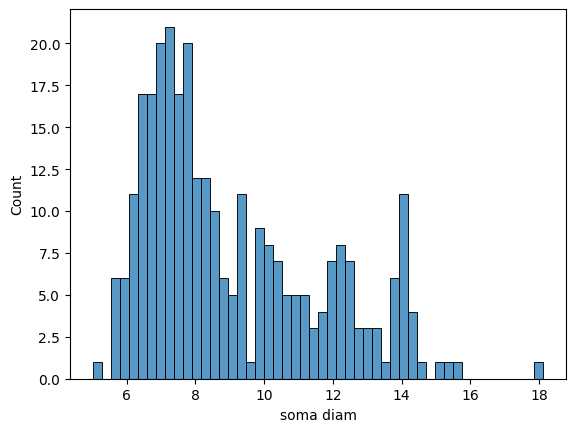

In [41]:
# df['binned'] = pd.cut(df['soma diam'], bins=np.arange(0,4000,200)).values
ax = sns.histplot(data = df[df['type'].isin(['mg1','mg2','sg1','sg2','sgx1','sgx2'])],x='soma diam',bins = 50)#,hue='type')

<AxesSubplot:xlabel='soma diam', ylabel='Density'>

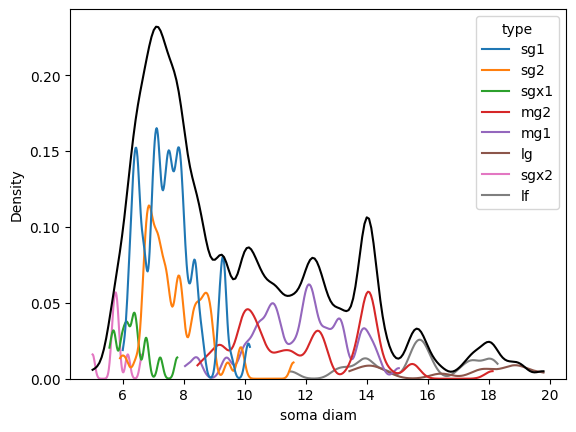

In [42]:

hfig,ax = plt.subplots(1)
sns.kdeplot(data = df[df['type'].isin(['mg1','mg2','sg1','sg2','sgx1','sgx2','lg','lf'])],x='soma diam',bw_adjust=0.25,cut=0,hue='type',ax=ax)
sns.kdeplot(data = df[df['type'].isin(['mg1','mg2','sg1','sg2','sgx1','sgx2','lg','lf'])],x='soma diam',bw_adjust=0.25,cut=0,color='black',ax=ax)

## Load into df_edges

In [9]:

for i,r in df_edges.iterrows():
    try:
        df_edges.loc[i,'pre_diam']=soma_diam[df_edges.loc[i,'pre']]
        df_edges.loc[i,'post_diam']=soma_diam[df_edges.loc[i,'post']]
    except:
        continue
df_edges.loc[:,'diam_diff'] = (df_edges['post_diam']-df_edges['pre_diam'])/df_edges['pre_diam']


# Cell types dict from df_edges

In [15]:
cell_types = {}

for i,r in df_edges.iterrows():
    cell_types[r['pre']]=r['pre_type'].lower()
    cell_types[r['post']]=r['post_type'].lower()
    


In [16]:
df_type = pd.DataFrame(cell_types.items(),columns = ['id','type'])

In [17]:
sum(df_type['type'].isin(['lf','lg']))


78

In [18]:
sum(df_type['type'].isin(['mg1','mg2']))

137

## cell types for all files in directory

In [39]:
nodefiles = get_cell_filepaths(Path(settings_dict['save_dir'])) 

In [44]:
cell_types = {}
not_typed = []
for x,f in nodefiles.items():
    cell = ecrest(settings_dict,filepath = f,launch_viewer=False)
    cell_types[x] = cell.get_ctype('manual') 
    if (cell.get_ctype('manual') == []) | (cell.get_ctype('manual') == ''):
        cell_types[x]=''
        not_typed.append(x)# print(f'cell {x} is not cell-typed in json')
        
print('the following cells are not typed in the main network')
print(not_typed)        
        

the following cells are not typed in the main network
[]


In [45]:
df_type = pd.DataFrame(cell_types.items(),columns = ['id','type'])

In [46]:
sum(df_type['type'].isin(['mg1','mg2']))

142

### mg without syn

In [71]:
all_mg = set([int(id_) for id_ in df_type[df_type['type'].isin(['mg1'])]['id'].values])

In [72]:
syn_mg = set(df_edges[df_edges['pre_type'].isin(['mg1'])]['pre'].values)

In [ ]:
all_mg.difference(syn_mg)

In [ ]:
[,
 ,
 43587455,
 44517560,
 44548558,
 128813171,
 129604015,
 213760634,
 214411806,
 214535386,
 215030183,
 216081986,
 298228381,
 299405462,
 301973569,
 303244291,
 386612701,
 387197529,
 387909811,
 472994717,
 473647416,
 473675810,
 556752337,
 557092670,
 557818053,
 558360429,
 559551706,
 560744270,
 560819551,
 ,
 642905044,
 ,
 ]

# synapses locations in df_syn

## absolute

In [322]:
df_syn = pd.read_csv(dirpath / 'graphs/df_postsyn.csv')
syn = 'post-synaptic'

In [323]:
syn_colors = {
    'sgx1':'#adebeb', #'#996633',
    'sgx2':'#cc9900',
    'sg1':'#00ffff',
    'sg2':'#ff9900',
    'grc-d':'#33cc33',
    'grc-s':'#e6e600',
    'dml':'#cccccc',
    'mg1':'#0000ff',
    'mg2':'#ff0000',
    'lg':'#8000c8',
    'lf':'#c80080',
    'aff':'#ffc0cb',
    'tsd':'#737373',
    'pe':'#550055',
    'pf':'#880088'
}

In [324]:
for v in ['x','y','z']:
    df_syn[v] = df_syn[v]/1000
    

In [325]:
df_syn['y'] = df_syn['y']*-1

In [326]:
df_syn[df_syn['pre_type'].isin(['pf'])]['pre'].unique()

array([282248367, 282249203, 282249246, 282264725, 282402582, 283408821,
       283408822, 283408851, 283409058, 283409102, 283409598, 283409751,
       283546452, 283546587, 283547027, 283548237, 283548467, 290291065,
       297177312, 368151099, 368151126, 368151283, 368151599, 369254559,
       369297193, 369312115, 369312294, 369312360, 369312699, 372899977,
       441321646, 463077884, 634858913, 636004167])

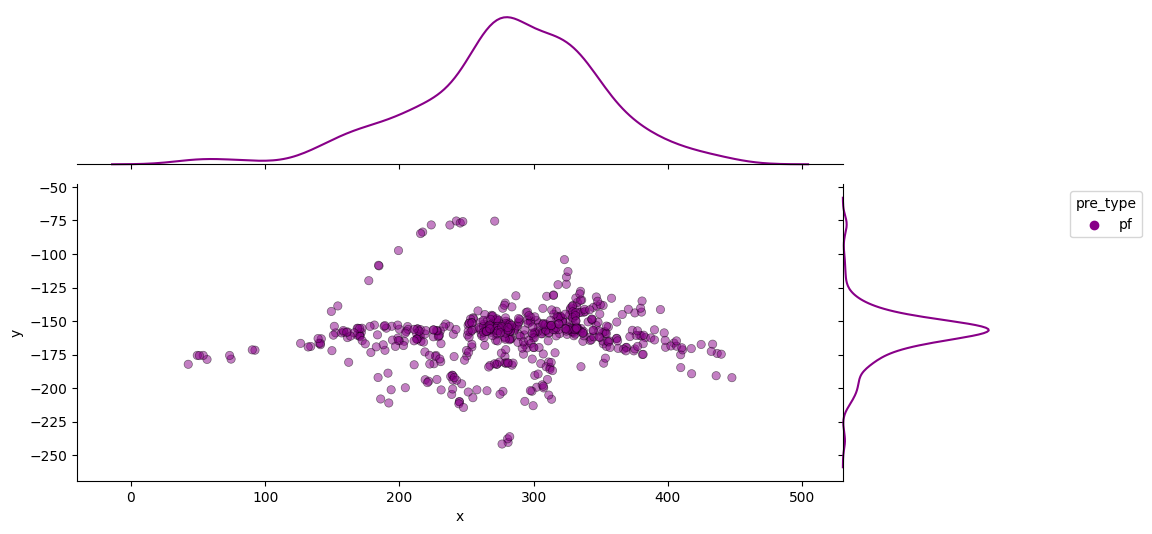

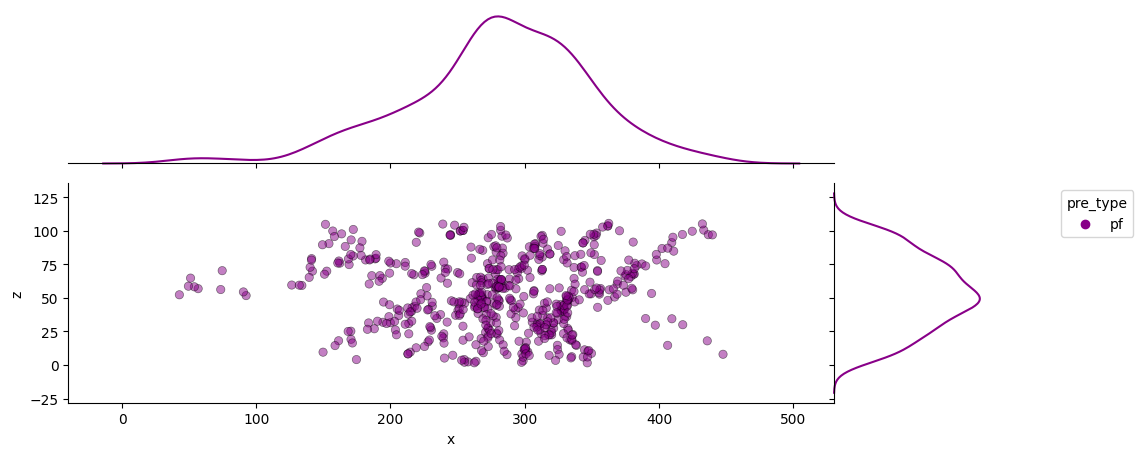

In [52]:

g = sns.jointplot(data=df_syn[df_syn['pre_type'].isin(['pf'])], #['aff','sg2','mg2','sg1','mg1','grc-d','grc-s']
                  x="x", y="y", hue="pre_type", height=10,
                  alpha = 0.5, edgecolor='black',palette = syn_colors,
                 marginal_kws=dict(common_norm=True,clip_on=0, fill=False), space=0)
# sns.scatterplot(x=[0],y=[0],color='black',s=100);

sns_joint_equal_axes(g);
sns.move_legend(plt.gca(), "upper right", bbox_to_anchor=(1.4, 1));

g = sns.jointplot(data=df_syn[df_syn['pre_type'].isin(['pf'])], #['aff','sg2','mg2','sg1','mg1','grc-d','grc-s']
                  x="x", y="z", hue="pre_type", height=10,
                  alpha = 0.5, edgecolor='black',palette = syn_colors,
                 marginal_kws=dict(common_norm=True,clip_on=0, fill=False), space=0)
# sns.scatterplot(x=[0],y=[0],color='black',s=100);

sns_joint_equal_axes(g);
sns.move_legend(plt.gca(), "upper right", bbox_to_anchor=(1.4, 1));

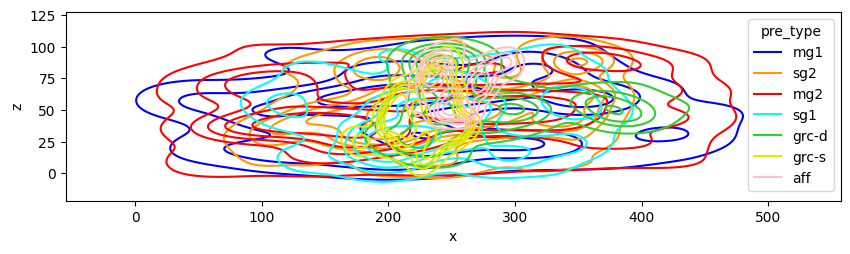

In [331]:
hfig,ax = plt.subplots(1,figsize=(10,10))

g = sns.kdeplot(ax = ax,data = df_syn[df_syn['pre_type'].isin(['aff','sg2','mg2','sg1','mg1','grc-d','grc-s'])],x='x',y='z',hue='pre_type',
                common_norm=True,palette=syn_colors,levels=6)#,thresh=0.15)#,fill=True,alpha = 0.25)

ax = plt.gca()
# ax.set_xlim(-100,100)
ax.set_aspect('equal')

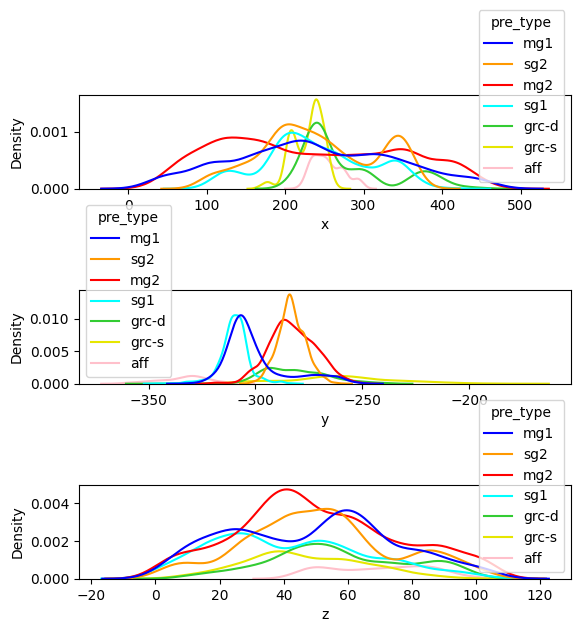

In [332]:
hfig,ax = plt.subplots(3,figsize=(6,6))
sns.kdeplot(ax=ax[0],data = df_syn[df_syn['pre_type'].isin(['aff','sg2','mg2','sg1','mg1','grc-d','grc-s'])],x='x',hue='pre_type',common_norm=True,clip_on=0,palette=syn_colors)
sns.kdeplot(ax=ax[1],data = df_syn[df_syn['pre_type'].isin(['aff','sg2','mg2','sg1','mg1','grc-d','grc-s'])],x='y',hue='pre_type',common_norm=True,clip_on=0,palette=syn_colors)
sns.kdeplot(ax=ax[2],data = df_syn[df_syn['pre_type'].isin(['aff','sg2','mg2','sg1','mg1','grc-d','grc-s'])],x='z',hue='pre_type',common_norm=True,clip_on=0,palette=syn_colors)
plt.tight_layout()

## relative to cell type soma 

### df_syn pre or post

In [21]:
df_syn = pd.read_csv(dirpath / 'graphs/df_postsyn.csv')
syn = 'post-synaptic'

In [22]:
df_syn.loc[df_syn['post_type'].isin(['dml']),'post_type']='mli'

df_syn.loc[df_syn['pre_type'].isin(['dml']),'pre_type']='mli'

### plot

In [23]:
syn_colors = {
    'sgx1':'#adebeb', #'#996633',
    'sgx2':'#cc9900',
    'sg1':'#00ffff',
    'sg2':'#ff9900',
    'grc-d':'#33cc33',
    'grc-s':'#e6e600',
    'dml':'#cccccc',
    'mg1':'#0000ff',
    'mg2':'#ff0000',
    'lg':'#8000c8',
    'lf':'#c80080',
    'aff':'#ffc0cb',
    'tsd':'#737373' 
}

In [24]:
df_syn

,Unnamed: 0,pre,post,structure,x,y,z,pre_type,post_type
0,0,126618353,387850816,basal dendrite,369584,313776,52260,mg1,mg2
1,1,126618353,303212610,basal dendrite,368736,314784,52560,mg1,mg2
2,2,126618353,394686712,unknown,370112,314832,52620,mg1,lf
3,3,126618353,394686712,basal dendrite,359792,314608,51390,mg1,lf
4,4,126618353,213605530,basal dendrite,360096,313808,51390,mg1,mg2
...,...,...,...,...,...,...,...,...,...
11186,11186,649572893,558020412,basal dendrite,175903,292039,87255,sg2,lg
11187,11187,649572893,558020412,basal dendrite,174970,291675,88275,sg2,lg
11188,11188,649572893,557973681,basal dendrite,176167,292010,88635,sg2,sg1
11189,11189,649572893,386224676,basal dendrite,172965,293461,99975,sg2,mg1


In [25]:
df_loc = pd.DataFrame(soma_loc.items(), columns=['cell', 'soma loc']).set_index('cell')
post_types_subset = ['lf','lg']

for c in df_loc.index:
    df_loc.loc[c,'type'] = cell_types[c]

# df_to_plot = df_loc[(df_loc.index.isin(df_progress[df_progress['completed']>0.9]['id'].values))&df_loc['type'].isin(['mg1','mg2','sg1','sg2'])].dropna()
df_to_plot = df_loc[df_loc['type'].isin(['mg1','mg2','sg1','sg2'])].dropna()

# Initialize an empty DataFrame
df_syn_locs = pd.DataFrame(columns=['x', 'y', 'z', 'cell_type'])

# Loop through cell types and extend the DataFrame
for i,r in df_to_plot.iterrows():
    # print(i,r)
    
    x,y,z = r['soma loc']
    cell = df_syn[(df_syn['pre'].isin([int(i)])) & (df_syn['post_type'].isin(post_types_subset))]
    # cell = ecrest(settings_dict,filepath = nodefiles[i],launch_viewer=False)
    positions = [(s[0]/1000-x,s[1]/1000-y,s[2]/1000-z) for s in list(cell[['x','y','z']].to_records(index=False))]#cell.cell_data['end_points']['post-synaptic']]
   
    # break
    cell_df = pd.DataFrame(positions, columns=['x', 'y', 'z'])  # Create DataFrame for the current cell type
    cell_df['cell_type'] = r['type']  # Add cell type column
    df_syn_locs = pd.concat([df_syn_locs, cell_df], ignore_index=True)  # Concatenate the current cell DataFrame to the main DataFrame

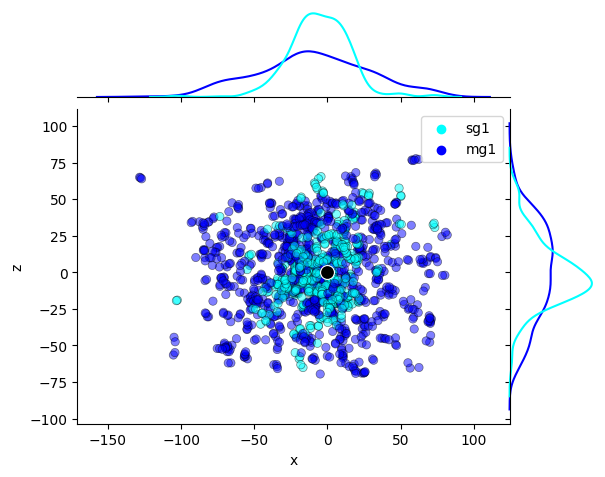

In [26]:
g = sns.jointplot(data=df_syn_locs[df_syn_locs['cell_type'].isin(['sg1','mg1'])], 
                  x="x", y="z", hue="cell_type",
                  alpha = 0.5, edgecolor='black',palette = syn_colors,
                 marginal_kws=dict(common_norm=False,clip_on=0, fill=False), space=0)
sns.scatterplot(x=[0],y=[0],color='black',s=100);

sns_joint_equal_axes(g);

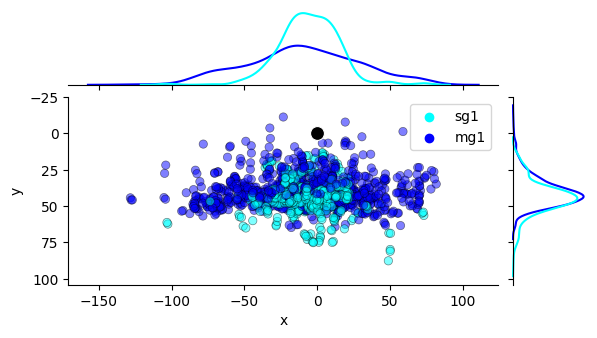

In [27]:
g = sns.jointplot(data=df_syn_locs[df_syn_locs['cell_type'].isin(['sg1','mg1'])], 
                  x="x", y="y", hue="cell_type",
                  alpha = 0.5, edgecolor='black',palette = syn_colors,
                 marginal_kws=dict(common_norm=False,clip_on=0, fill=False), ratio=5)
sns.scatterplot(x=[0],y=[0],color='black',s=100);

g.ax_joint.invert_yaxis()

g = sns_joint_equal_axes(g)

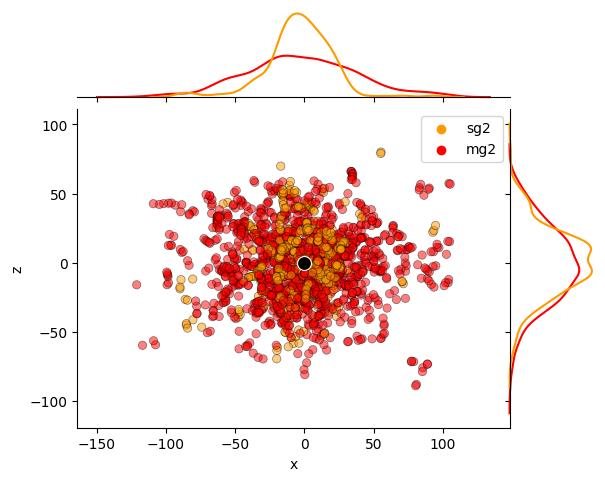

In [28]:
g = sns.jointplot(data=df_syn_locs[df_syn_locs['cell_type'].isin(['sg2','mg2'])], 
                  x="x", y="z", hue="cell_type",
                  alpha = 0.5, edgecolor='black',palette = syn_colors,
                 marginal_kws=dict(common_norm=False,clip_on=0, fill=False), space=0)
sns.scatterplot(x=[0],y=[0],color='black',s=100);

sns_joint_equal_axes(g);

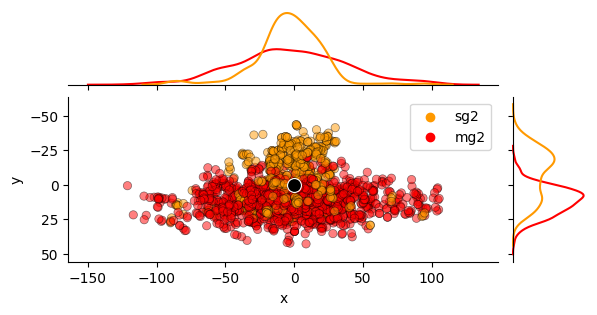

In [29]:
g = sns.jointplot(data=df_syn_locs[df_syn_locs['cell_type'].isin(['sg2','mg2'])], 
                  x="x", y="y", hue="cell_type",
                  alpha = 0.5, edgecolor='black',palette = syn_colors,
                 marginal_kws=dict(common_norm=False,clip_on=0, fill=False), ratio=5)
sns.scatterplot(x=[0],y=[0],color='black',s=100);

g.ax_joint.invert_yaxis()

g = sns_joint_equal_axes(g)

In [ ]:
g.ax_joint.set_aspect('equal')

this needs to be restricted to data from cells within 150 microns of edge in x (and only analyzed in x) to avoid edge effects


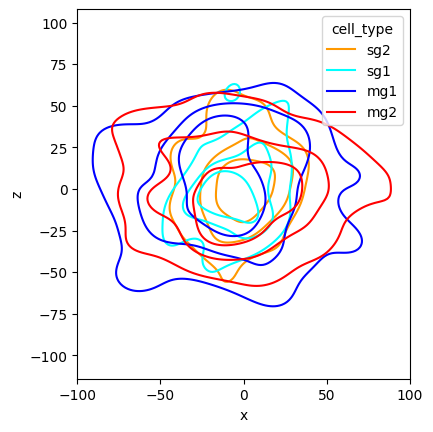

In [31]:
# hfig,ax = plt.subplots(1,figsize=(3,6))
g = sns.kdeplot(data = df_syn_locs,x='x',y='z',hue='cell_type',common_norm=False,palette=syn_colors,levels=4,thresh=0.15)#,fill=True,alpha = 0.25)

ax = plt.gca()
ax.set_xlim(-100,100)
ax.set_aspect('equal')

# hfig,ax = plt.subplots(3,figsize=(6,6))
# sns.kdeplot(ax=ax[0],data = df_syn_locs,x='x',hue='cell_type',common_norm=False,clip_on=0,palette=syn_colors)
# sns.kdeplot(ax=ax[1],data = df_syn_locs,x='y',hue='cell_type',common_norm=False,clip_on=0,palette=syn_colors)
# sns.kdeplot(ax=ax[2],data = df_syn_locs,x='z',hue='cell_type',common_norm=False,clip_on=0,palette=syn_colors)
# plt.tight_layout()

print('this needs to be restricted to data from cells within 150 microns of edge in x (and only analyzed in x) to avoid edge effects')

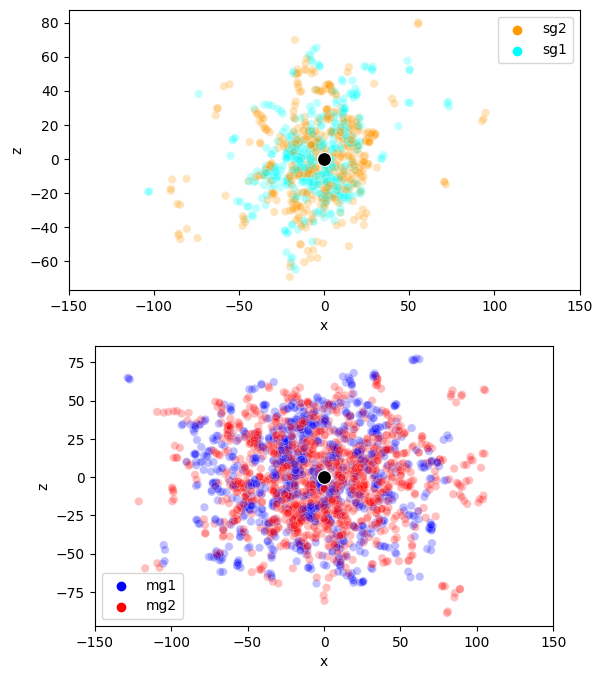

In [32]:
hfig,ax = plt.subplots(2,figsize=(10,8))
sns.scatterplot(ax=ax[0],data=df_syn_locs[df_syn_locs['cell_type'].isin(['sg1','sg2'])],
                x = 'x', y='z',alpha = 0.25,hue='cell_type',palette=syn_colors) #,color='black'
sns.scatterplot(ax=ax[0],x=[0],y=[0],color='black',s=100)
sns.scatterplot(ax=ax[1],data=df_syn_locs[df_syn_locs['cell_type'].isin(['mg1','mg2'])],
                x = 'x', y='z',alpha = 0.25,hue='cell_type',palette=syn_colors) #,color='black'
sns.scatterplot(ax=ax[1],x=[0],y=[0],color='black',s=100)
for a in ax:
    a.set_xlim(-150,150)
    # a.set_ylim(-3000,3000)
    a.set_aspect('equal')

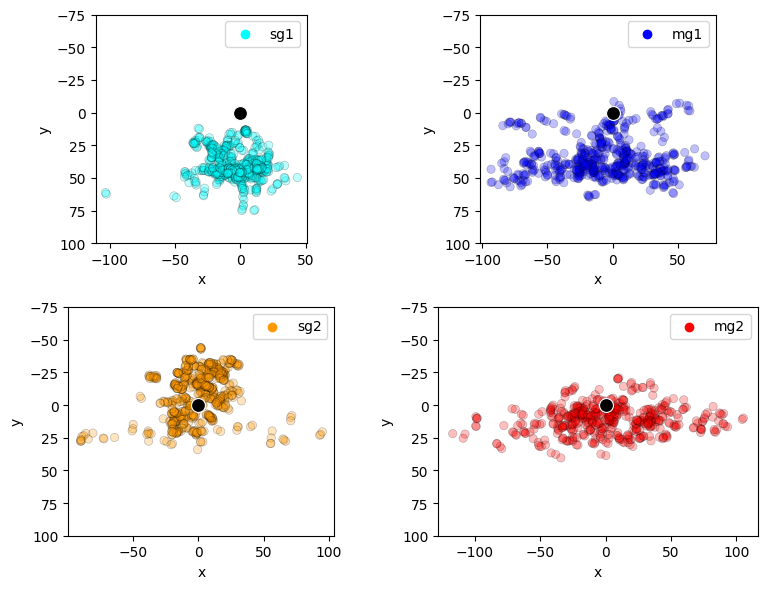

In [1582]:
hfig,ax = plt.subplots(2,2,figsize=(8,6))
sns.scatterplot(ax=ax[0,0],data=df_syn_locs[df_syn_locs['cell_type'].isin(['sg1'])],
                x = 'x', y='y',alpha = 0.25,hue='cell_type',palette=syn_colors,edgecolor="black") #,color='black'
sns.scatterplot(ax=ax[1,0],data=df_syn_locs[df_syn_locs['cell_type'].isin(['sg2'])],
                x = 'x', y='y',alpha = 0.25,hue='cell_type',palette=syn_colors,edgecolor="black") #,color='black'
sns.scatterplot(ax=ax[0,1],data=df_syn_locs[df_syn_locs['cell_type'].isin(['mg1'])],
                x = 'x', y='y',alpha = 0.25,hue='cell_type',palette=syn_colors,edgecolor="black") #,color='black'
sns.scatterplot(ax=ax[1,1],data=df_syn_locs[df_syn_locs['cell_type'].isin(['mg2'])],
                x = 'x', y='y',alpha = 0.25,hue='cell_type',palette=syn_colors,edgecolor="black") #,color='black'
for a in ax:
    for a2 in a:
        sns.scatterplot(ax=a2,x=[0],y=[0],color='black',s=100)

for a in ax:
    for a2 in a:
        # a2.set_xlim(-200,200)
        a2.set_ylim(-75,100)
        a2.set_aspect('equal')
        a2.invert_yaxis()

plt.tight_layout()


# Completeness of synapses



In [33]:
all_types = set(df_edges['pre_type'].unique()) | set(df_edges['post_type'].unique()) #- set(['glia'])
c_type_check = all_types #['mg1','mg2','sg1','sg2','grc']

df_progress = pd.DataFrame(columns = ['id','type','soma-diam','n_syn','done','todo','completed'])
for c in df_edges['pre'].unique():
    
    if (df_edges[df_edges['pre'] == c]['pre_type'].unique()[0] in c_type_check):

        c_df = df_edges[df_edges['pre'].isin([c])]
        n_syn_done = c_df['weight'].sum()

        cell = ecrest(settings_dict,filepath = nodefiles[str(c)],launch_viewer=False)
        
        if len(cell.cell_data['end_points'][syn])>0:
            # try:
            cell_dict = {
                'id': cell.cell_data['metadata']['main_seg']['base'],
                'type': cell_types[c], #cell.get_ctype("manual"),
                # 'soma-diam': soma_diam[c],
                'n_syn': len(cell.cell_data['end_points'][syn]),
                'done': n_syn_done, #len(c_df),
                'todo': len(cell.cell_data['end_points'][syn]) - n_syn_done, #len(c_df),
                'completed': n_syn_done / (len(cell.cell_data['end_points'][syn]))
                }
            # except:
            #     print(f'error on {c}')
            #     continue
        
        if len(cell.cell_data['end_points'][syn])==0:
            cell_dict = {
                'id': cell.cell_data['metadata']['main_seg']['base'],
                'type': cell_types[c], #cell.get_ctype("manual"),
                # 'soma-diam': soma_diam[c],
                'n_syn': np.NaN,
                'done': n_syn_done, #len(c_df),
                'todo': np.NaN, #len(c_df),
                'completed': np.NaN
                }
            # print(f'error on {c}')
            # continue

        df_progress = pd.concat([df_progress,pd.DataFrame([cell_dict])])

In [34]:
len(df_progress[df_progress['type'].isin(['pf'])][['id','n_syn']].sort_values('n_syn'))

35

<AxesSubplot:xlabel='n_syn', ylabel='Count'>

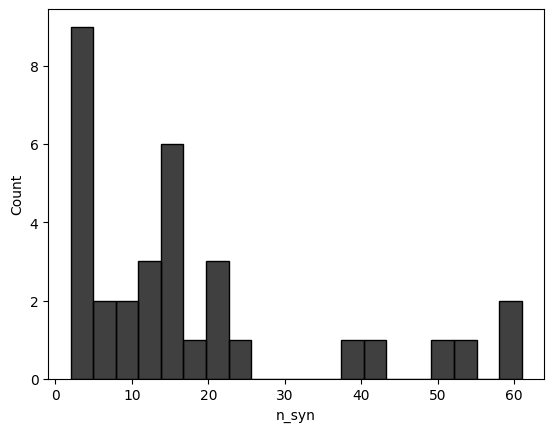

In [35]:
sns.histplot(df_progress[(df_progress['type'].isin(['pf']))&(df_progress['n_syn']>1)]['n_syn'],color='black',bins=20)#['id'].values

In [38]:
df_progress[df_progress['type'].isin(['mg1'])].sort_values('todo')

,id,type,soma-diam,n_syn,done,todo,completed
0,386224676,mg1,NaN,64,64,0,1.000000
0,213669553,mg1,NaN,84,84,0,1.000000
0,474111084,mg1,NaN,13,13,0,1.000000
0,299496636,mg1,NaN,49,49,0,1.000000
0,213501262,mg1,NaN,112,112,0,1.000000
0,213590737,mg1,NaN,44,44,0,1.000000
0,128737253,mg1,NaN,33,32,1,0.969697
0,472114046,mg1,NaN,31,30,1,0.967742
0,300131090,mg1,NaN,53,52,1,0.981132
0,43622486,mg1,NaN,23,21,2,0.913043


In [458]:
df_progress[df_progress['completed']>0.9][['id','type','completed']].groupby('type').describe()

completed                                                            
          count      mean       std       min       25%       50%  75%  max
type                                                                       
grc-d      10.0  1.000000  0.000000  1.000000  1.000000  1.000000  1.0  1.0
grc-s       9.0  0.995181  0.010926  0.967742  1.000000  1.000000  1.0  1.0
mg1        14.0  0.965866  0.039119  0.902439  0.932321  0.975415  1.0  1.0
mg2        11.0  0.973491  0.038005  0.905405  0.940972  1.000000  1.0  1.0
mli         5.0  0.983707  0.025115  0.940000  0.986111  0.992424  1.0  1.0
pe          4.0  1.000000  0.000000  1.000000  1.000000  1.000000  1.0  1.0
pf         34.0  1.000000  0.000000  1.000000  1.000000  1.000000  1.0  1.0
sg1        16.0  0.999381  0.002475  0.990099  1.000000  1.000000  1.0  1.0
sg2        15.0  0.984473  0.032087  0.907407  0.997191  1.000000  1.0  1.0
sgx1        1.0  1.000000       NaN  1.000000  1.000000  1.000000  1.0  1.0
sgx2        1.0  1.000000       NaN  1.000000  1.000000  1.000000  1.0  1.0
tsd         1.0  1.000000       NaN  1.000000  1.000000  1.000000  1.0  1.0

# Filtered df_edges

In [430]:
# Filter by pre and/or post cell type

network_types = (set(df_edges['pre_type'].unique()) | set(df_edges['post_type'].unique())) - set(['glia'])#,'tsd','dml']) #'tsd','dml','sgx1','sgx2'])
# df_edges = df_edges[(df_edges['pre_type'].isin(network_types - set(['sgx1','sgx2'])))&(df_edges['post_type'].isin(network_types))]# - set(['lg','lf'])
df_edges = df_edges[(df_edges['pre_type'].isin(network_types))&(df_edges['post_type'].isin(network_types))]# - set(['lg','lf'])

In [359]:
df_edges = df_edges[df_edges['pre'].isin([int(id_) for id_ in df_progress[(df_progress['type'].isin(['mli'])) & (df_progress['n_syn']>1)]['id'].values])]

In [439]:


# Filter by completeness of synaptic reconstructions
df_edges_completed = df_edges[df_edges['pre'].isin([int(id_) for id_ in df_progress[df_progress['completed']>0.9]['id'].values])]
df_edges = pd.concat([df_edges_completed,df_edges[df_edges['pre_type'].isin(['aff'])]])
   

# if syn=='post-synaptic':
#     df_syn_completed = df_syn[df_syn['pre'].isin([int(id_) for id_ in df_progress[df_progress['completed']>0.9]['id'].values])]
#     df_syn = pd.concat([df_syn_completed,df_syn[df_syn['pre_type'].isin(['aff'])]])
    
    
# if syn=='pre-synaptic':
#     df_syn = df_syn[df_syn['pre'].isin([int(id_) for id_ in df_progress[df_progress['completed']>0.3]['id'].values])]


In [440]:
df_edges

,pre,post,pre_type,post_type,weight
0,130781211,215526370,sg2,lg,32
1,306461085,301863996,sg2,lg,32
3,300131090,392814322,mg1,lf,29
4,41579854,393078033,mg1,lf,29
7,213669553,393464000,mg1,lf,21
...,...,...,...,...,...
3554,61319896,661102306,aff,uk,1
3570,61319896,214799314,aff,mg2,1
3571,61319896,213605530,aff,mg2,1
3572,61319896,142571993,aff,uk,1


# Connectivity Matrix quantifications

Most appropriately used when focusing on df_edges from either df_syn pre or post, but not the combined df_edges

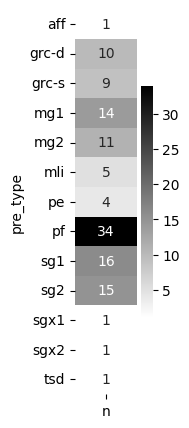

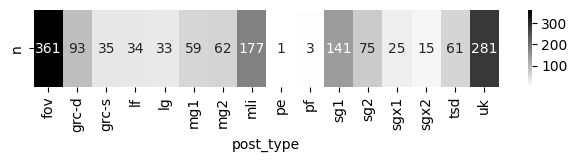

In [441]:
# Calculate the total number of 'pre' nodes for each 'pre_type'
total_pre_nodes = df_edges.groupby('pre_type')['pre'].nunique().reset_index()
total_pre_nodes.loc[:,'number labeled']='n'
total_pre_nodes = total_pre_nodes.pivot(index='pre_type', columns='number labeled', values='pre')

hfig,ax = plt.subplots(1,figsize=(1,5))
sns.heatmap(total_pre_nodes, annot=True, cmap="gray_r", fmt=".0f")
ax.set_xlabel('')

###
# Calculate the total number of 'post' nodes for each 'post_type'
total_post_nodes = df_edges.groupby('post_type')['post'].nunique().reset_index()
total_post_nodes.loc[:,'number reconstructed']='n'
total_post_nodes = total_post_nodes.pivot(index='number reconstructed', columns='post_type', values='post')

hfig,ax = plt.subplots(1,figsize=(7.5,1))
sns.heatmap(total_post_nodes, annot=True, cmap="gray_r", fmt=".0f");
ax.set_ylabel('');

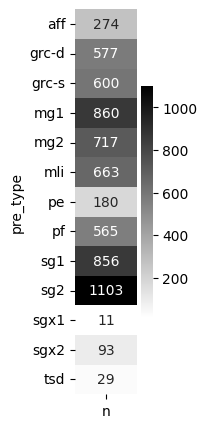

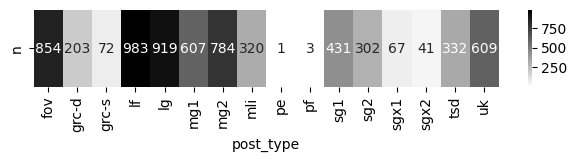

In [442]:
grouped = df_edges.groupby(['pre_type', 'post_type'])['weight'].sum().reset_index()
matrix = grouped.pivot(index='pre_type', columns='post_type', values='weight')#.fillna(0)

### pre
df_pivot = df_edges.groupby('pre_type')['weight'].sum().reset_index()
df_pivot.loc[:,'n']='n'
total_pre_syn = df_pivot.pivot(index='pre_type', columns='n',values='weight')

hfig,ax = plt.subplots(1,figsize=(1,5))
sns.heatmap(total_pre_syn, annot=True, cmap="gray_r", fmt=".0f")
ax.set_xlabel('')

### post
df_pivot = df_edges.groupby('post_type')['weight'].sum().reset_index()
df_pivot.loc[:,'n']='n'
total_post_syn = df_pivot.pivot(index='n', columns='post_type',values='weight')

hfig,ax = plt.subplots(1,figsize=(7.5,1))
sns.heatmap(total_post_syn,annot=True, cmap="gray_r", fmt=".0f");
ax.set_ylabel('');

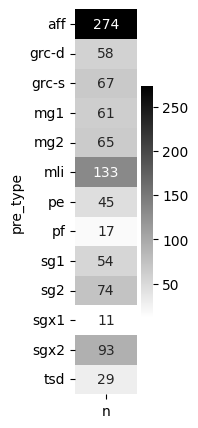

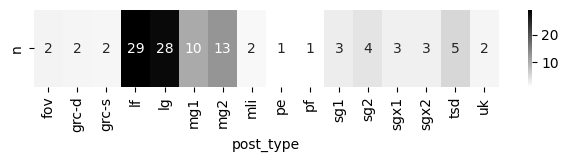

In [443]:
'''mean synapses per cell'''

hfig,ax = plt.subplots(1,figsize=(1,5))
sns.heatmap(total_pre_syn / total_pre_nodes, annot=True, cmap="gray_r", fmt=".0f")
ax.set_xlabel('')

hfig,ax = plt.subplots(1,figsize=(7.5,1))
sns.heatmap(total_post_syn / total_post_nodes,annot=True, cmap="gray_r", fmt=".0f");
ax.set_ylabel('');

<AxesSubplot:xlabel='post_type', ylabel='pre_type'>

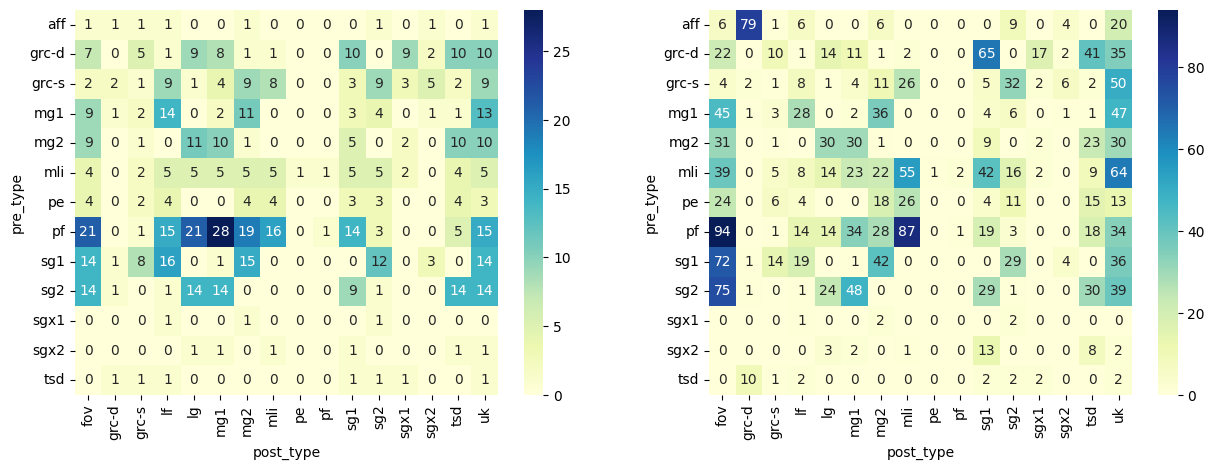

In [444]:
'''
This code does not repeat counting a post cell if more than one pre cell synapses on it
'''
# Calculate the number of 'pre' nodes of each 'pre_type' for each 'post_type'
pre_type_contributions = df_edges.groupby(['pre_type', 'post_type'])['pre'].nunique().unstack(fill_value=0)

# Calculate the number of 'post' nodes of each 'post_type' for each 'pre_type'
post_type_contributions = df_edges.groupby(['pre_type', 'post_type'])['post'].nunique().unstack(fill_value=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.heatmap(pre_type_contributions, annot=True, cmap="YlGnBu", ax=axes[0])
sns.heatmap(post_type_contributions, annot=True, cmap="YlGnBu", ax=axes[1])

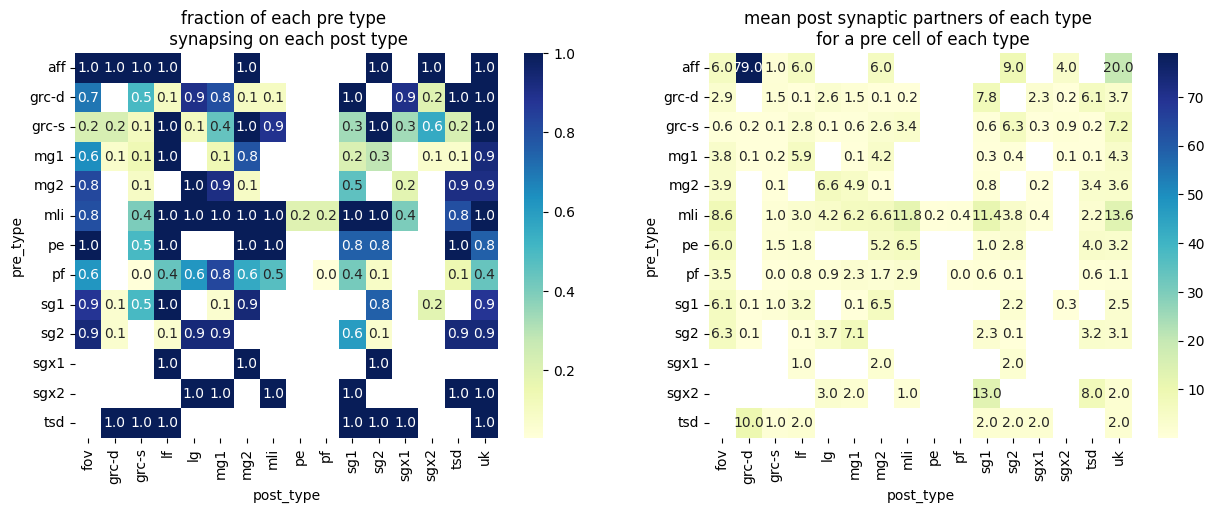

In [445]:
# Calculate the number of edges for each pre-post pair (unique_counts['n_post'])
# Different from the number of unique post nodes
edge_counts = df_edges.groupby(['pre_type', 'post_type','pre'])[['post']].nunique().reset_index().groupby(['pre_type', 'post_type'])['post'].sum().reset_index().rename(columns={'post': 'n_post'})
# The following gives the same as "pre_type_contributions" but with more code: unique_counts['n_pre'] = df_edges.groupby(['pre_type', 'post_type'])[['pre','post']].nunique().reset_index().groupby(['pre_type', 'post_type'])['pre'].sum().reset_index().rename(columns={'pre': 'n_pre'})['n_pre']
pre_counts = df_edges.groupby(['pre_type', 'post_type'])['pre'].nunique().reset_index().rename(columns={'pre': 'n_pre'})
edge_counts['n_pre'] = pre_counts['n_pre']

n_pre_all = [df_edges.groupby(['pre_type'])['pre'].nunique()[p_] for p_ in edge_counts['pre_type']]# unique_counts['pre_type']]

edge_counts['percent_pre'] = edge_counts['n_pre'].div(n_pre_all)
edge_counts['mean_post_count'] = edge_counts['n_post'].div(n_pre_all)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

result_pivot = edge_counts.pivot(index='pre_type', columns='post_type', values='percent_pre')
sns.heatmap(result_pivot, annot=True, fmt=".1f", cmap="YlGnBu", ax = axes[0])

result_pivot = edge_counts.pivot(index='pre_type', columns='post_type', values='mean_post_count')#.fillna(0)
sns.heatmap(result_pivot, annot=True, fmt=".1f", cmap="YlGnBu", ax = axes[1])#,vmax=10)

axes[0].set_title('fraction of each pre type \n synapsing on each post type')
axes[1].set_title('mean post synaptic partners of each type \n for a pre cell of each type');

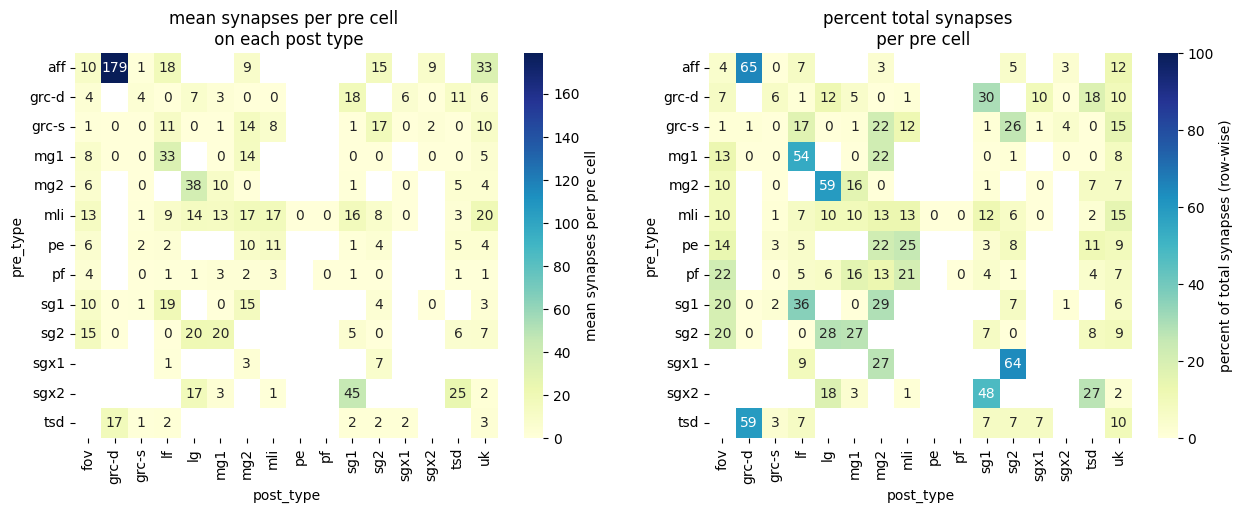

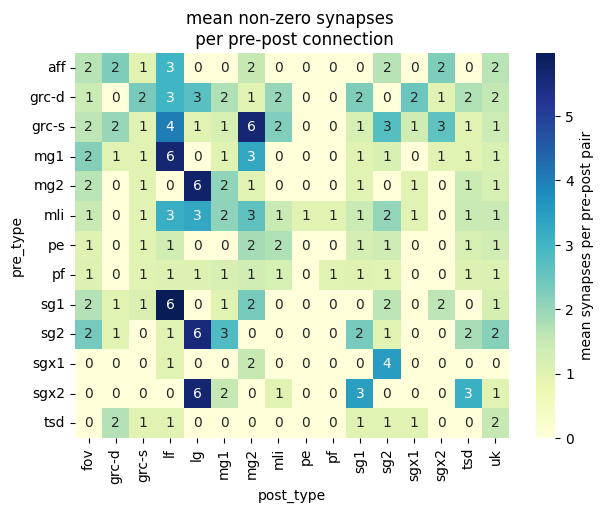

In [446]:
res = df_edges.groupby(['pre_type','post_type'])[['weight']].sum(numeric_only=True)#.reset_index()
syn_total = res.groupby('pre_type')['weight'].sum()
n_pre = df_edges.groupby(['pre_type'])['pre'].nunique()#.reset_index()['pre']
n_post = df_edges.groupby(['pre_type'])['post'].nunique()#.reset_index()['pre']

res.loc[:,'weight_norm'] = np.round(res.weight / syn_total *100)
res.loc[:,'weight_per_cell'] = res.weight / n_pre
# res.loc[:,'weight_per_pair'] = res.weight / n_post #* does not work because this is div by all npost, not those in that pairing

# hfig,ax = plt.subplots(1,figsize=(5,2))
fig, axes = plt.subplots(1,2, figsize=(15, 5))
sns.heatmap(res.reset_index().pivot(index='pre_type', columns='post_type', values='weight_per_cell'),#.fillna(0),
            annot=True,cmap="YlGnBu",vmin=0,ax=axes[0], fmt=".0f", #,vmax=100
           cbar_kws={'label': 'mean synapses per pre cell'})

sns.heatmap(res.reset_index().pivot(index='pre_type', columns='post_type', values='weight_norm'),#.fillna(0),
            annot=True,cmap="YlGnBu",vmin=0,vmax=100,ax=axes[1], #
           cbar_kws={'label': 'percent of total synapses (row-wise)'})

axes[0].set_title('mean synapses per pre cell \n on each post type')
axes[1].set_title('percent total synapses \n per pre cell');


edge_counts = df_edges.groupby(['pre_type', 'post_type','pre'])[['post']].nunique().reset_index().groupby(['pre_type', 'post_type'])['post'].sum().reset_index().rename(columns={'post': 'n_post'})
res.loc[:,'n_edges']=edge_counts['n_post'].values
res.loc[:,'u_edges']=res['weight']/res['n_edges']
fig, axes = plt.subplots(1, figsize=(7, 5))
sns.heatmap(res.reset_index().pivot(index='pre_type', columns='post_type', values='u_edges').fillna(0),
            annot=True,cmap="YlGnBu",vmin=0,ax=axes, fmt=".0f",
           cbar_kws={'label': 'mean synapses per pre-post pair'});
axes.set_title('mean non-zero synapses \n per pre-post connection');

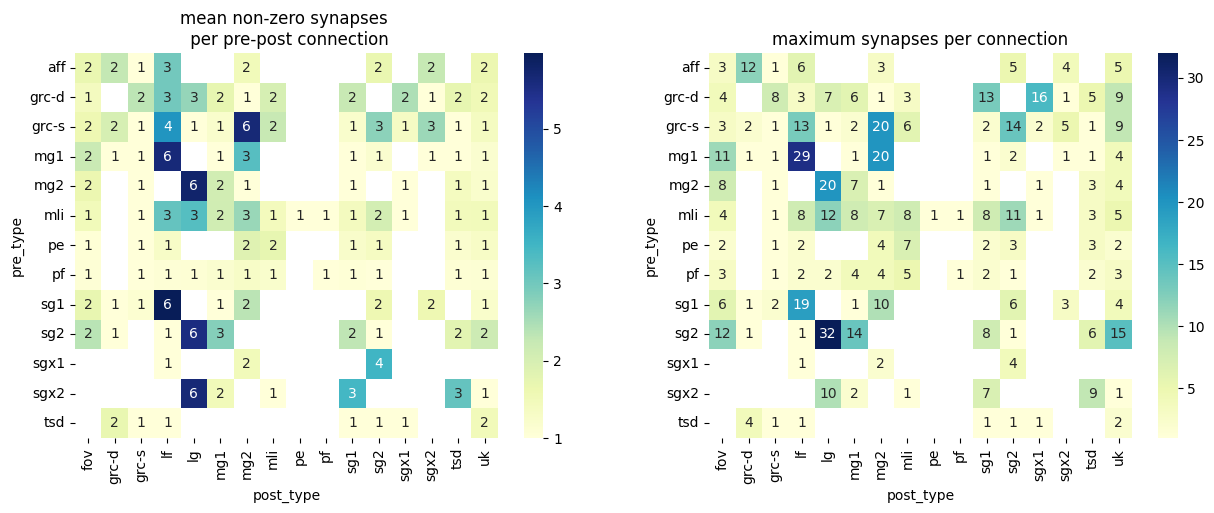

In [447]:

grouped = df_edges.groupby(['pre_type', 'post_type'])['weight'].agg(['mean', 'min', 'max']).reset_index()

# Pivot the DataFrame to get matrices for median, min, and max weights
mean_matrix = grouped.pivot(index='pre_type', columns='post_type', values='mean')
min_matrix = grouped.pivot(index='pre_type', columns='post_type', values='min')
max_matrix = grouped.pivot(index='pre_type', columns='post_type', values='max')

# Create subplots for median, min, and max matrices
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Set titles for subplots
axes[0].set_title('mean non-zero synapses \n per pre-post connection');
# axes[1].set_title('Minimum Connection Weights')
axes[1].set_title('maximum synapses per connection')

# Plot the heatmaps for median, min, and max matrices
sns.heatmap(mean_matrix, annot=True, fmt=".0f", cmap="YlGnBu", ax=axes[0])
# sns.heatmap(min_matrix, annot=True, fmt=".0f", cmap="YlGnBu", ax=axes[1])
sns.heatmap(max_matrix, annot=True, fmt=".0f", cmap="YlGnBu", ax=axes[1])

# plt.tight_layout()
plt.show();

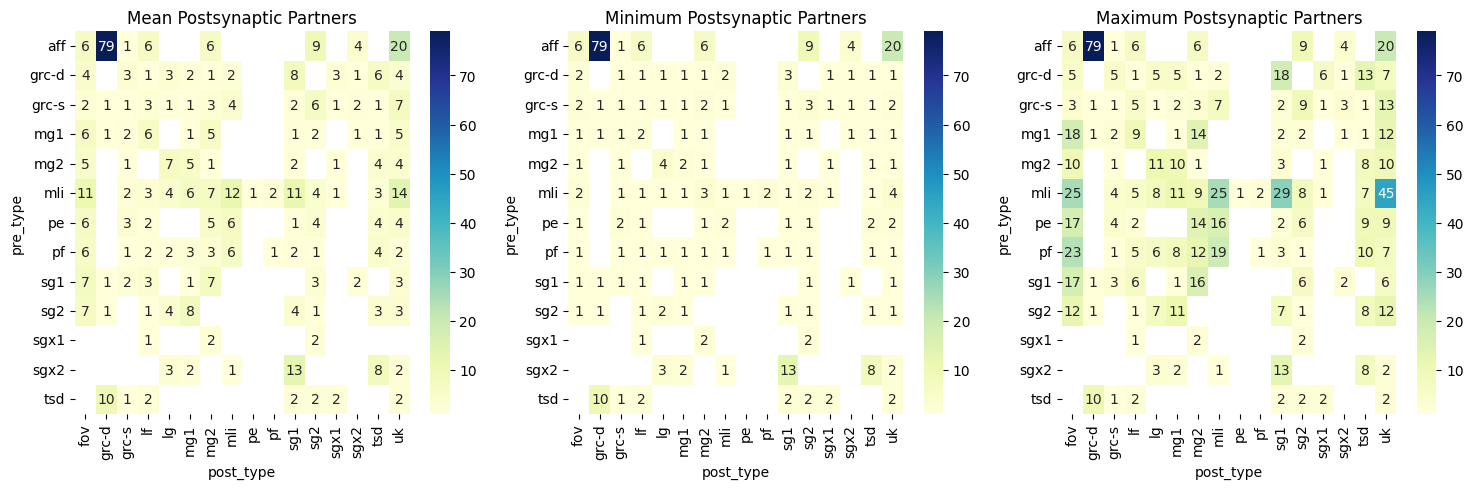

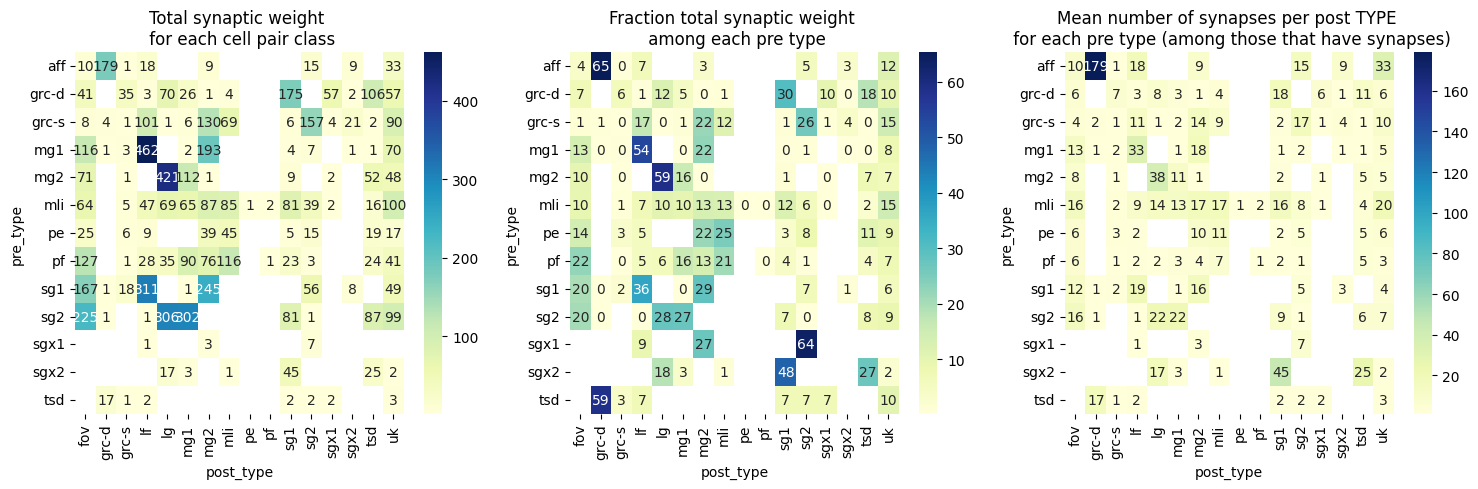

In [448]:
'''
connection partners only among pre cells that synapse on that type
'''

# Calculate the average number of unique 'post' cells for each 'pre_type'
average_counts = df_edges.groupby(['pre_type', 'post_type', 'pre'])['post'].nunique().groupby(['pre_type', 'post_type']).mean().unstack() # average_counts = average_counts.applymap(lambda x: f'{x:.1f}').astype(float)
min_counts = df_edges.groupby(['pre_type', 'post_type', 'pre'])['post'].nunique().groupby(['pre_type', 'post_type']).min().unstack() # min_counts = min_counts.applymap(lambda x: f'{x:.1f}').astype(float)
max_counts = df_edges.groupby(['pre_type', 'post_type', 'pre'])['post'].nunique().groupby(['pre_type', 'post_type']).max().unstack() # max_counts = max_counts.applymap(lambda x: f'{x:.1f}').astype(float)

# Create subplots for median, min, and max matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Set titles for subplots
axes[0].set_title('Mean Postsynaptic Partners')
axes[1].set_title('Minimum Postsynaptic Partners')
axes[2].set_title('Maximum Postsynaptic Partners')

# Plot the heatmaps for median, min, and max matrices
sns.heatmap(average_counts, annot=True, cmap="YlGnBu", ax=axes[0], fmt=".0f")
sns.heatmap(min_counts, annot=True, cmap="YlGnBu", ax=axes[1], fmt=".0f")
sns.heatmap(max_counts, annot=True, cmap="YlGnBu", ax=axes[2], fmt=".0f")

plt.tight_layout()
# plt.show();

grouped = df_edges.groupby(['pre_type', 'post_type'])['weight'].sum().reset_index()

# Pivot the DataFrame to get the desired matrix
matrix = grouped.pivot(index='pre_type', columns='post_type', values='weight')#.fillna(0)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.heatmap(matrix, annot=True, fmt="0.0f", cmap="YlGnBu", ax=axes[0])

matrix_normalized = matrix.div(matrix.sum(axis=1), axis=0).div(0.01)
sns.heatmap(matrix_normalized, annot=True, fmt="0.0f", cmap="YlGnBu", ax=axes[1])

average_weight = df_edges.groupby(['pre_type', 'post_type', 'pre'])['weight'].sum().groupby(['pre_type', 'post_type']).mean().unstack() # average_counts = average_counts.applymap(lambda x: f'{x:.1f}').astype(float)
sns.heatmap(average_weight, annot=True, fmt="0.0f", cmap="YlGnBu", ax=axes[2])

# Set titles for subplots
axes[0].set_title('Total synaptic weight \n for each cell pair class')
axes[1].set_title('Fraction total synaptic weight \n among each pre type')
axes[2].set_title('Mean number of synapses per post TYPE \n for each pre type (among those that have synapses)')

plt.tight_layout();

## As stacked bar

In [454]:
syn_colors = {
    'sgx1':'#adebeb', #'#996633',
    'sgx2':'#cc9900',
    'sg1':'#00ffff',
    'sg2':'#ff9900',
    'grc-d':'#33cc33',
    'grc-s':'#e6e600',
    'mli':'#cccccc',
    'mg1':'#0000ff',
    'mg2':'#ff0000',
    'lg':'#8000c8',
    'lf':'#c80080',
    'aff':'#ffc0cb',
    'tsd':'#ccccff',
    'uk':'#86592d',
    'fov':'#000000',
    'focal types':'#33cc33',
    'pf':'#ffcce6',
    'pe':'#ffcce6'
}

In [450]:
matrix_normalized

post_type,fov,grc-d,grc-s,lf,lg,mg1,mg2,mli,pe,pf,sg1,sg2,sgx1,sgx2,tsd,uk
pre_type,,,,,,,,,,,,,,,,
aff,3.649635,65.328467,0.364964,6.569343,NaN,NaN,3.284672,NaN,NaN,NaN,NaN,5.474453,NaN,3.284672,NaN,12.043796
grc-d,7.105719,NaN,6.065858,0.519931,12.131716,4.506066,0.173310,0.693241,NaN,NaN,30.329289,NaN,9.878683,0.346620,18.370884,9.878683
grc-s,1.333333,0.666667,0.166667,16.833333,0.166667,1.000000,21.666667,11.500000,NaN,NaN,1.000000,26.166667,0.666667,3.500000,0.333333,15.000000
mg1,13.488372,0.116279,0.348837,53.720930,NaN,0.232558,22.441860,NaN,NaN,NaN,0.465116,0.813953,NaN,0.116279,0.116279,8.139535
mg2,9.902371,NaN,0.139470,NaN,58.716876,15.620642,0.139470,NaN,NaN,NaN,1.255230,NaN,0.278940,NaN,7.252441,6.694561
mli,9.653092,NaN,0.754148,7.088989,10.407240,9.803922,13.122172,12.820513,0.15083,0.301659,12.217195,5.882353,0.301659,NaN,2.413273,15.082956
pe,13.888889,NaN,3.333333,5.000000,NaN,NaN,21.666667,25.000000,NaN,NaN,2.777778,8.333333,NaN,NaN,10.555556,9.444444
pf,22.477876,NaN,0.176991,4.955752,6.194690,15.929204,13.451327,20.530973,NaN,0.176991,4.070796,0.530973,NaN,NaN,4.247788,7.256637
sg1,19.509346,0.116822,2.102804,36.331776,NaN,0.116822,28.621495,NaN,NaN,NaN,NaN,6.542056,NaN,0.934579,NaN,5.724299


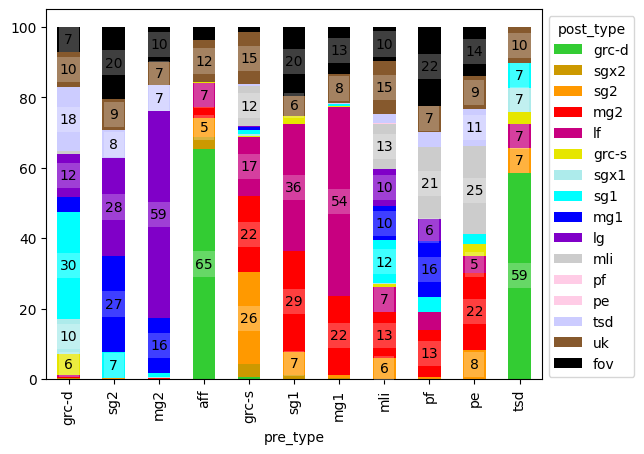

In [457]:
res = df_edges.groupby(['pre_type','post_type'])[['weight']].sum(numeric_only=True)#.reset_index()
syn_total = res.groupby('pre_type')['weight'].sum()
n_pre = df_edges.groupby(['pre_type'])['pre'].nunique()#.reset_index()['pre']
n_post = df_edges.groupby(['pre_type'])['post'].nunique()#.reset_index()['pre']

res.loc[:,'weight_norm'] = res.weight / syn_total *100

matrix_normalized = res.reset_index().pivot(index='pre_type', columns='post_type', values='weight_norm').fillna(0)


if syn == 'post-synaptic':
    order_pre = ['grc-d','sg2','mg2','aff','grc-s','sg1','mg1','mli','pf','pe','tsd']#,'dml']#,'dml'] #['grc-d','sg2','mg2','lf','grc-s','sg1','mg1','lg','dml']
    order_post = ['grc-d','sgx2','sg2','mg2','lf','grc-s','sgx1','sg1','mg1','lg','mli','pf','pe','tsd','uk','fov']
if syn == 'pre-synaptic':
    order_pre = ['grc-d','sg2','mg2','lf','grc-s','sg1','mg1','lg']#,'dml'] #['grc-d','sg2','mg2','lf','grc-s','sg1','mg1','lg','dml']
    order_post = ['aff','grc-d','sgx2','sg2','mg2','grc-s','sgx1','sg1','mg1']

ax = matrix_normalized.loc[order_pre,order_post].plot.bar(stacked=True,color = syn_colors)

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height >= 5:
        t = ax.text(x+width/2, 
                y+height/2, 
                f'{height:.0f}', 
                horizontalalignment='center', 
                verticalalignment='center')
        t.set_bbox(dict(facecolor='white', alpha=0.25, edgecolor = 'None'))
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.2, 1))

In [56]:
df_combined_col = deepcopy(matrix_normalized)
df_combined_col[columns_to_combine].sum(axis=1)
df_combined_col.loc[:,'focal types'] = df_combined_col[columns_to_combine].sum(axis=1)

In [58]:
df_combined_col.drop(columns=columns_to_combine)

post_type,dml,fov,tsd,uk,focal types
pre_type,,,,,
aff,0.0,4.0,0.0,13.0,83.0
dml,14.0,4.0,1.0,8.0,74.0
grc-d,1.0,7.0,18.0,10.0,64.0
grc-s,12.0,1.0,0.0,15.0,72.0
mg1,0.0,10.0,0.0,9.0,81.0
mg2,0.0,10.0,7.0,7.0,76.0
sg1,0.0,20.0,0.0,6.0,74.0
sg2,0.0,21.0,8.0,9.0,62.0


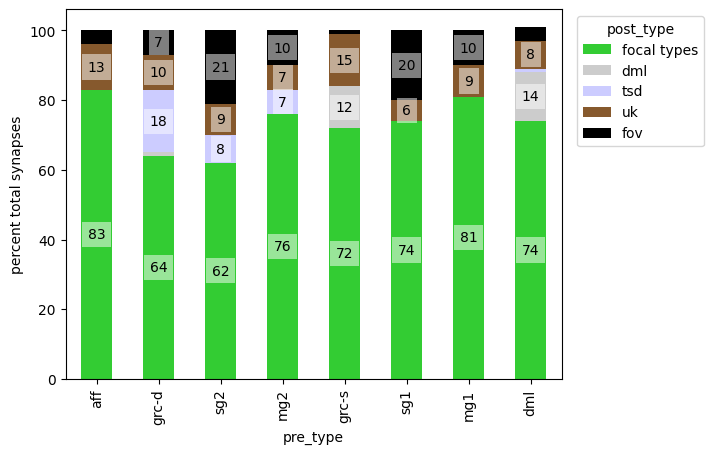

In [68]:
columns_to_combine=['grc-d', 'grc-s', 'lf', 'lg', 'mg1', 'mg2', 'sg1', 'sg2', 'sgx1', 'sgx2']
df_combined_col = deepcopy(matrix_normalized)
df_combined_col['focal types'] = df_combined_col[columns_to_combine].sum(axis=1)

# Drop the specified columns
df_combined_col.drop(columns=columns_to_combine,inplace=True)

order_pre = ['aff','grc-d','sg2','mg2','grc-s','sg1','mg1','dml']#,'dml'] #['grc-d','sg2','mg2','lf','grc-s','sg1','mg1','lg','dml']
order_post = ['focal types','dml','tsd','uk','fov']

ax = df_combined_col.loc[order_pre,order_post].plot.bar(stacked=True,color = syn_colors)

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height >= 5:
        t = ax.text(x+width/2, 
                y+height/2, 
                f'{height:.0f}', 
                horizontalalignment='center', 
                verticalalignment='center')
        t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor = 'None'))
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.3, 1))
ax.set_ylabel('percent total synapses');

In [43]:
matrix_normalized.index

Index(['aff', 'dml', 'grc-d', 'grc-s', 'mg1', 'mg2', 'sg1', 'sg2'], dtype='object', name='pre_type')

# cell variability among most completed

In [361]:

def typed_progress_df(df_edges,pre_type):

    res = df_edges[df_edges['pre_type'].isin(pre_type)].groupby(
        ['pre','post_type'])[['weight']].sum(numeric_only=True)#.reset_index()
    denom = res.groupby('pre')['weight'].sum()

    # res.weight = np.round(res.weight / denom *100)

    data = res.reset_index(level=[0,1]).fillna(0)
    
    return data

## stacked bar

In [362]:
res = df_edges.groupby(['pre_type','post_type'])[['weight']].sum(numeric_only=True)#.reset_index()
syn_total = res.groupby('pre_type')['weight'].sum()
n_pre = df_edges.groupby(['pre_type'])['pre'].nunique()#.reset_index()['pre']
n_post = df_edges.groupby(['pre_type'])['post'].nunique()#.reset_index()['pre']

res.loc[:,'weight_norm'] = res.weight / syn_total *100

matrix_normalized = res.reset_index().pivot(index='pre_type', columns='post_type', values='weight_norm').fillna(0)

In [363]:
matrix_normalized

post_type,fov,grc-s,lf,lg,mg1,mg2,mli,pe,pf,sg1,sg2,sgx1,tsd,uk
pre_type,,,,,,,,,,,,,,
mli,9.370425,0.732064,7.467057,10.248902,9.809663,13.469985,12.445095,0.146413,0.292826,11.859444,5.856515,0.292826,2.781845,15.22694


In [ ]:
if syn == 'post-synaptic':
    order_pre = ['grc-d','sg2','mg2','aff','grc-s','sg1','mg1']#,'dml']#,'dml'] #['grc-d','sg2','mg2','lf','grc-s','sg1','mg1','lg','dml']
    order_post = ['grc-d','sgx2','sg2','mg2','lf','grc-s','sgx1','sg1','mg1','lg']#,'dml','tsd','uk','fov']
if syn == 'pre-synaptic':
    order_pre = ['grc-d','sg2','mg2','lf','grc-s','sg1','mg1','lg']#,'dml'] #['grc-d','sg2','mg2','lf','grc-s','sg1','mg1','lg','dml']
    order_post = ['aff','grc-d','sgx2','sg2','mg2','grc-s','sgx1','sg1','mg1']

ax = matrix_normalized.loc[order_pre,order_post].plot.bar(stacked=True,color = syn_colors)

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height >= 5:
        t = ax.text(x+width/2, 
                y+height/2, 
                f'{height:.0f}', 
                horizontalalignment='center', 
                verticalalignment='center')
        t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor = 'None'))
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.2, 1))

## bar

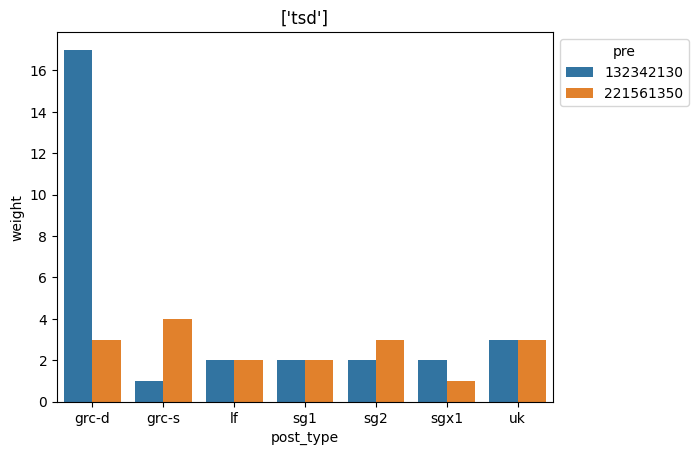

In [431]:
pre_type = ['tsd']
data = typed_progress_df(df_edges,pre_type)
ax = sns.barplot(data = data, y = 'weight', x = 'post_type', hue = 'pre',dodge=True)
# ax = sns.barplot(data = df_edges[df_edges['pre_type'].isin(pre_type)], y = 'weight', x = 'post_type', hue = 'pre',dodge=True)
plt.title(pre_type)
# plt.ylim(0,100);
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [221]:
data['pre'].unique()

array([290291065, 297177312, 372899977, 441321646, 463077884, 634858913,
       636004167])

In [ ]:
pre_type = ['pe']
data = typed_progress_df(df_edges,pre_type)
ax=sns.barplot(data = data, y = 'weight', x = 'post_type', hue = 'pre',dodge=True)
plt.title(pre_type)
# plt.ylim(0,100);
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1));

## heatmaps

In [102]:
t = 'pf'
display(df_edges[(df_edges['pre_type']==t) & (df_edges['pre'].isin([283546452]))].groupby(
        ['pre','pre_type','post_type']).count())

display(df_edges[(df_edges['pre_type']==t) & (df_edges['pre'].isin([283546452]))].groupby(
        ['pre','pre_type','post_type']).sum())

post  weight
pre       pre_type post_type              
283546452 pf       fov          23      23
                   lf            1       1
                   lg            1       1
                   mg1           7       7
                   mg2           1       1
                   mli          11      11
                   uk            6       6

post  weight
pre       pre_type post_type                    
283546452 pf       fov        2272103360      25
                   lf          393464000       1
                   lg          474898913       1
                   mg1        2107582186      10
                   mg2         126649726       1
                   mli        2056413227      15
                   uk          993569887       7

In [436]:
count_type = 'ncells' #'nsyn' #

types_ =  ['tsd'] #df_edges['pre_type'].unique() # ['mg1','mg2','lg','lf','sg1','sg2','sgx1','sgx2','grc-d','grc-s','aff','dml']#
df_map = pd.DataFrame()
for t in types_:
    if count_type == 'nsyn':
        df_grouped = df_edges[df_edges['pre_type']==t].groupby(
            ['pre','pre_type','post_type']).sum(numeric_only=True).reset_index().pivot(
            index='pre', columns='post_type', values='weight').fillna(0).reset_index()
    
    if count_type == 'ncells':
        df_grouped = df_edges[df_edges['pre_type']==t].groupby(
            ['pre','pre_type','post_type']).count().reset_index().pivot(
            index='pre', columns='post_type', values='post').fillna(0).reset_index()
    
    df_grouped['pre_type']=t
    df_map = pd.concat([df_map,df_grouped])
    
df_map = df_map.fillna(0)
df_map = df_map.set_index('pre')
df_map = df_map.drop(['pre_type'],axis=1)

<AxesSubplot:xlabel='post_type', ylabel='pre'>

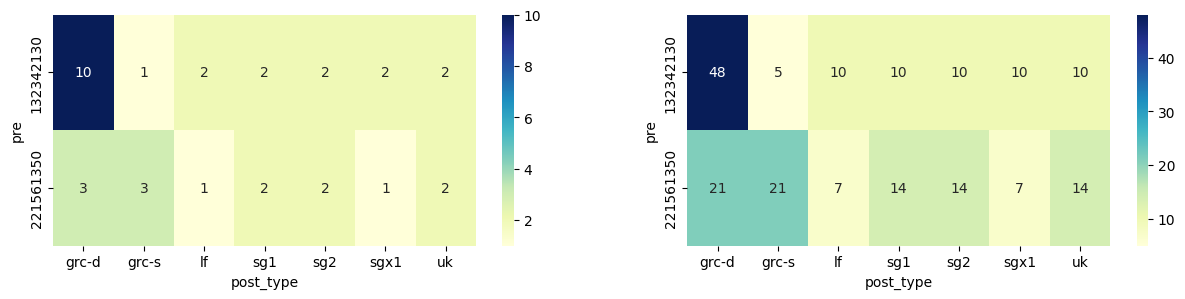

In [437]:
fig, axes = plt.subplots(1, 2, figsize=(15, 3))
sns.heatmap(data=df_map, annot=True, fmt="0.0f", cmap="YlGnBu", ax=axes[0])
sns.heatmap(data=df_map.div(df_map.sum(axis=1),axis=0).mul(100).round(0), annot=True, fmt="0.0f", cmap="YlGnBu", ax=axes[1])

<AxesSubplot:xlabel='lf', ylabel='mg2'>

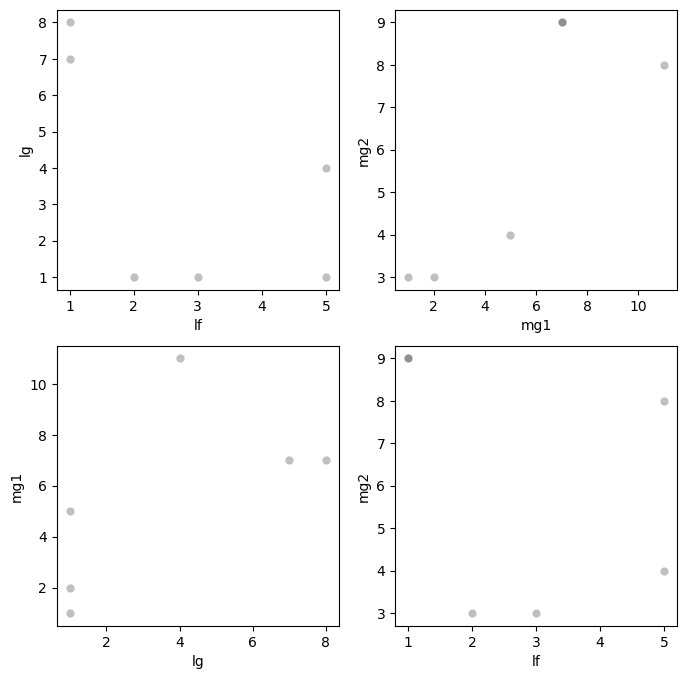

In [368]:
hfig,ax = plt.subplots(2,2,figsize=(8,8))
sns.scatterplot(df_map, x = 'lf', y = 'lg', ax = ax[0][0],alpha = 0.25,color = 'black')
sns.scatterplot(df_map, x = 'mg1', y = 'mg2', ax = ax[0][1],alpha = 0.25,color = 'black')
sns.scatterplot(df_map, x = 'lg', y = 'mg1', ax = ax[1][0],alpha = 0.25,color = 'black')
sns.scatterplot(df_map, x = 'lf', y = 'mg2', ax = ax[1][1],alpha = 0.25,color = 'black')

<AxesSubplot:xlabel='post_type', ylabel='pre'>

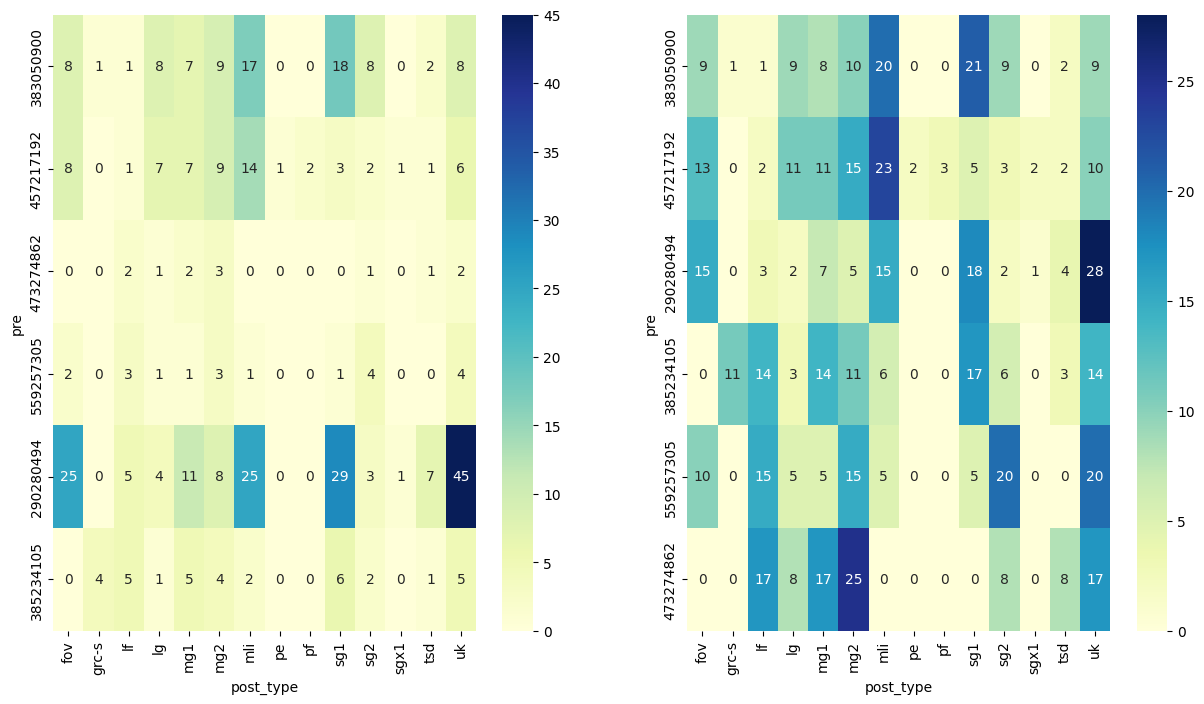

In [369]:
fig, axes = plt.subplots(1, 2, figsize=(15, 8))
df_sorted = df_map.sort_values('lf')
sns.heatmap(data=df_sorted, annot=True, fmt="0.0f", cmap="YlGnBu", ax=axes[0])
df_norm = df_sorted.div(df_sorted.sum(axis=1),axis=0).mul(100).round(0)
sns.heatmap(data=df_norm.sort_values('lf'), annot=True, fmt="0.0f", cmap="YlGnBu", ax=axes[1])

In [411]:
syn_colors = {
    'sgx1':'#adebeb', #'#996633',
    'sgx2':'#cc9900',
    'sg1':'#00ffff',
    'sg2':'#ff9900',
    'grc-d':'#33cc33',
    'grc-s':'#e6e600',
    'mli':'#cccccc',
    'mg1':'#0000ff',
    'mg2':'#ff0000',
    'lg':'#8000c8',
    'lf':'#c80080',
    'aff':'#ffc0cb',
    'tsd':'#ccccff',
    'uk':'#86592d',
    'fov':'#000000',
    'focal types':'#33cc33',
    'pf':'#ffcce6'
}

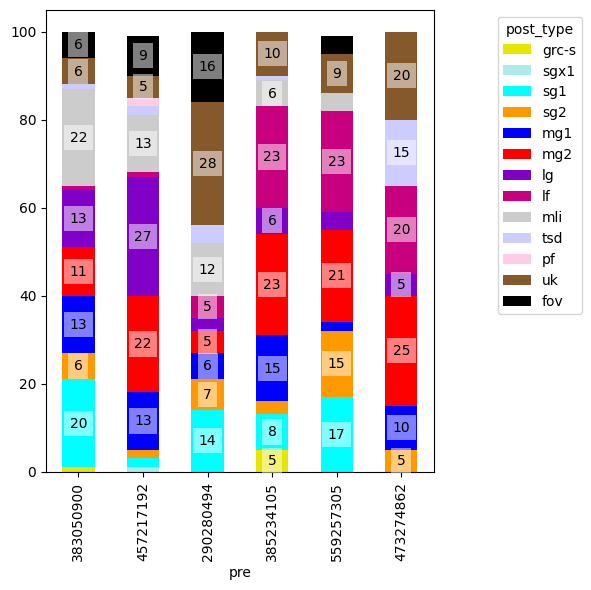

In [412]:
df_norm = df_map.div(df_map.sum(axis=1),axis=0).mul(100).round(0)

order_pre = [383050900,457217192,290280494,385234105,559257305,473274862]
order_post = ['grc-s','sgx1','sg1','sg2','mg1','mg2','lg','lf','mli','tsd','pf','uk','fov']

ax = pd.DataFrame(df_norm.loc[order_pre,order_post]).plot(kind='bar', stacked=True, figsize=(5, 6),color = syn_colors)

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height >= 5:
        t = ax.text(x+width/2, 
                y+height/2, 
                f'{height:.0f}', 
                horizontalalignment='center', 
                verticalalignment='center')
        t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor = 'None'))
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.4, 1))

### mean/total/proportion cells per type (collapse across rows within columns)

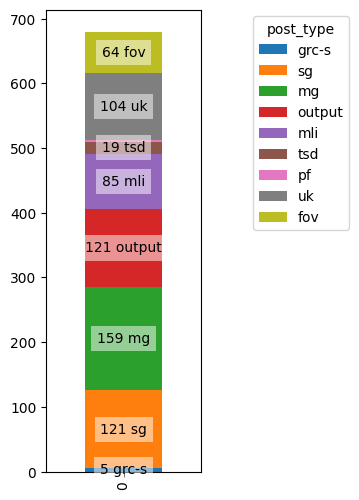

In [417]:
df_map['output'] = df_map[['lf', 'lg']].sum(axis=1)
df_map['mg'] = df_map[['mg1', 'mg2']].sum(axis=1)
df_map['sg'] = df_map[['sg1', 'sg2']].sum(axis=1)

# Drop the original columns
df_map = df_map.drop(['lf', 'lg', 'mg1', 'mg2', 'sg1', 'sg2'], axis=1)

df_sum = df_map.sum()

order_post = ['grc-s','sg','mg','output','mli','tsd','pf','uk','fov']
df_sum_ordered = df_sum.loc[order_post]



ax = pd.DataFrame(df_sum_ordered).T.plot(kind='bar', stacked=True, figsize=(2, 6))#,color = syn_colors)

for p,cell_type in zip(ax.patches, order_post):
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height >= 5:
        t = ax.text(x+width/2, 
                y+height/2, 
                f'{height:.0f} {cell_type}', 
                horizontalalignment='center', 
                verticalalignment='center')
        t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor = 'None'))
sns.move_legend(ax, "upper right", bbox_to_anchor=(2, 1))

In [160]:
df_sum_ordered

post_type
grc-s       1.0
sg         26.0
mg        166.0
output     61.0
mli       115.0
tsd        24.0
pf          1.0
uk         42.0
fov       127.0
dtype: float64

In [126]:
df_map.sum() / df_map.sum().sum() * 100

post_type
fov       23.935091
grc-s      0.202840
mli       19.472617
pf         0.202840
tsd        4.462475
uk         7.707911
output    11.359026
mg        27.586207
sg         5.070994
dtype: float64

# Density and Proximity of connected cells

In [225]:
df_loc = pd.DataFrame.from_dict(soma_loc, orient='index', columns=['x', 'y', 'z']).dropna()
for c in df_loc.index:
    df_loc.loc[c,'type'] = cell_types[c]

In [229]:
df_loc.loc[df_loc['type'].isin(['mg1','mg2']),'type']='mg'
df_loc.loc[df_loc['type'].isin(['mg1','mg2']),'type']='output'

In [230]:
df_loc

,x,y,z,type
128614407,176.752031,264.280258,23.776078,sg1
480346174,273.944563,313.730172,75.376117,uk
301973569,387.064000,272.800000,47.760000,mg
43622486,59.805104,269.666914,16.534804,mg
386392158,240.488000,267.312000,56.355000,mg
...,...,...,...,...
127672247,262.412719,254.396906,25.799978,sg2
306585534,393.857312,295.699187,47.734711,sg1
214736845,281.279437,266.214844,35.405213,sg1
47194079,120.784000,290.564000,4.500000,sg2


In [249]:
def euclidean_distance(df, cell_id1, cell_id2):
    if cell_id1 not in df.index or cell_id2 not in df.index:
        raise ValueError("Cell IDs not found in the DataFrame.")

    # Extract the coordinates for the two cell IDs
    coordinates1 = df.loc[cell_id1, ['x', 'y', 'z']]
    coordinates2 = df.loc[cell_id2, ['x', 'y', 'z']]

    # Check for NaN values in the coordinates
    if any(coordinates1.isna()) or any(coordinates2.isna()):
        raise ValueError("Coordinates contain NaN values.")

    # Calculate the Euclidean distance
    distance = np.linalg.norm(coordinates1 - coordinates2)

    return distance

In [256]:
# Example usage
# Assuming df is your DataFrame
distance = euclidean_distance(df_loc, 301973569, 43622486)
print("Euclidean distance:", distance)

Euclidean distance: 328.76011685595546


In [257]:
result_list = []

for i,r in df_edges.iterrows():
    
    
    try:
        df_edges.loc[i,'distance'] = euclidean_distance(df_loc, r['pre'], r['post'])
    except ValueError:
        df_edges.loc[i,'distance'] = np.NaN
# df_edges

In [261]:
df_edges[(df_edges['pre_type'].isin(['mg1','mg2'])) & (df_edges['post_type'].isin(['lg','lf']))].dropna()['pre']

,pre,post,post_type,pre_type,weight,distance
20,41579854,49625293,lf,mg1,7,45.539296
42,41579854,393078033,lf,mg1,29,63.896908
48,41579854,479001172,lf,mg1,13,75.552030
51,41579854,481274292,lf,mg1,1,87.726946
74,42632020,49453764,lf,mg1,6,49.618838
...,...,...,...,...,...,...
5682,558300217,301787806,lg,mg2,3,54.309460
5686,558300217,474898913,lg,mg2,3,90.814376
5687,558300217,560681683,lg,mg2,9,43.582935
5688,558360429,393325331,lf,mg1,2,79.829452


array([[<AxesSubplot:title={'center':'pre'}>,
        <AxesSubplot:title={'center':'post'}>],
       [<AxesSubplot:title={'center':'weight'}>,
        <AxesSubplot:title={'center':'distance'}>]], dtype=object)

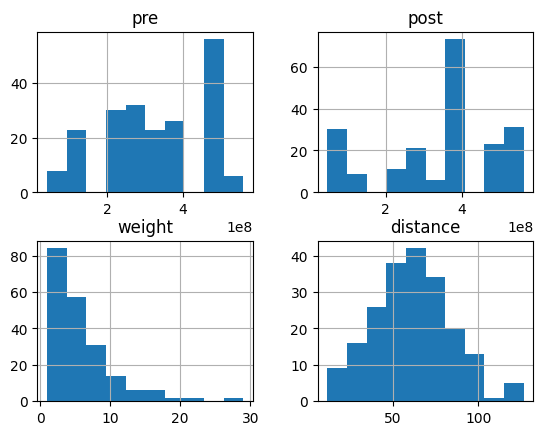

In [262]:
df_edges[(df_edges['pre_type'].isin(['mg1','mg2'])) & (df_edges['post_type'].isin(['lg','lf']))].dropna().hist()

In [299]:
sub_df = df_edges[(df_edges['pre_type'].isin(['mg1','mg2'])) & (df_edges['post_type'].isin(['lg','lf']))].dropna()

<AxesSubplot:xlabel='distance', ylabel='weight'>

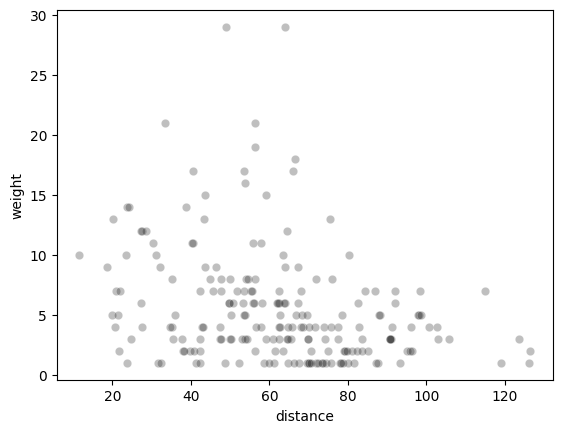

In [302]:
sns.scatterplot(sub_df, x='distance',y='weight',color='black',alpha = 0.25)

In [284]:
def combine_neurons(df_edges, combine='post'):
    if combine not in ['pre', 'post']:
        raise ValueError("Combine must be either 'pre' or 'post'.")

    # Select columns based on combine parameter
    group_cols = ['pre'] if combine == 'post' else ['post']
    value_cols = ['weight', 'distance']

    # Group by the selected columns and calculate mean and standard deviation
    result_df = df_edges.groupby(group_cols)[value_cols].agg(['mean', 'std']).reset_index()

    # Rename columns for better readability
    result_df.columns = ['_'.join(col).strip() for col in result_df.columns.values]

    return result_df

In [296]:
# do the analysis on the subset of the df for which 
# the pre is an mg, the post is an output, and the location of both somas is known
sub_df = df_edges[(df_edges['pre_type'].isin(['mg1','mg2'])) & (df_edges['post_type'].isin(['lg','lf']))].dropna()

result_df = combine_neurons(sub_df, combine='post')

result_df.head(5)

,pre_,weight_mean,weight_std,distance_mean,distance_std
0,41579854,12.500000,12.041595,68.178795,17.957137
1,42632020,3.333333,2.516611,61.656555,12.418550
2,43622486,15.000000,NaN,59.086083,NaN
3,126618353,1.500000,0.707107,85.424238,13.661970
4,127870654,6.000000,2.121320,76.540455,19.984571


<AxesSubplot:ylabel='distance_mean'>

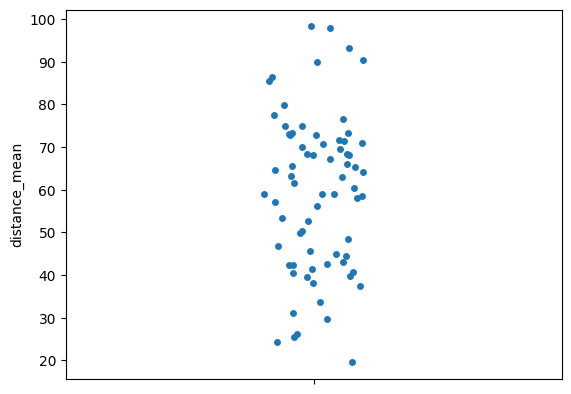

In [297]:
sns.stripplot(result_df,y='distance_mean')

Text(0, 0.5, 'n mg cells')

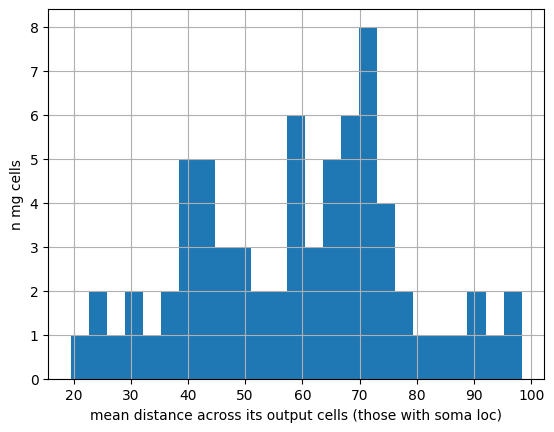

In [311]:
ax = result_df['distance_mean'].hist(bins=25)

ax.set_xlabel('mean distance across its output cells (those with soma loc)')
ax.set_ylabel('n mg cells')


<AxesSubplot:xlabel='distance_mean', ylabel='weight_mean'>

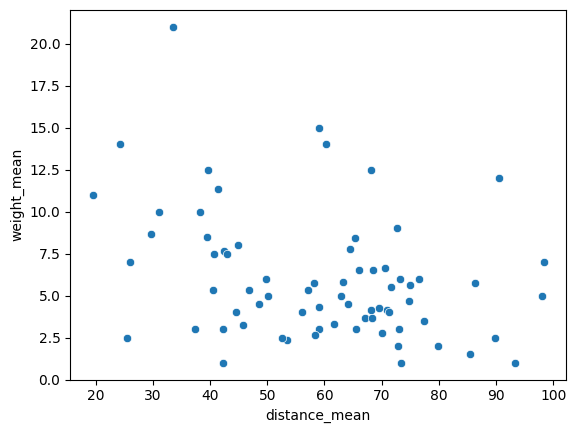

In [298]:
sns.scatterplot(result_df,x='distance_mean',y='weight_mean')

In [312]:
# do the analysis on the subset of the df for which 
# the pre is an mg, the post is an output, and the location of both somas is known
sub_df = df_edges[(df_edges['pre_type'].isin(['mg1','mg2'])) & (df_edges['post_type'].isin(['lg','lf']))].dropna()

result_df = combine_neurons(sub_df, combine='pre')

result_df.head(5)

,post_,weight_mean,weight_std,distance_mean,distance_std
0,45633163,14.000000,NaN,23.847896,NaN
1,48573302,5.200000,2.949576,66.320505,15.251722
2,48929295,2.800000,2.683282,73.125271,14.566075
3,49453764,3.900000,2.685351,78.045915,25.870017
4,49625293,3.555556,2.006932,77.923535,22.324786


Text(0, 0.5, 'n output cells')

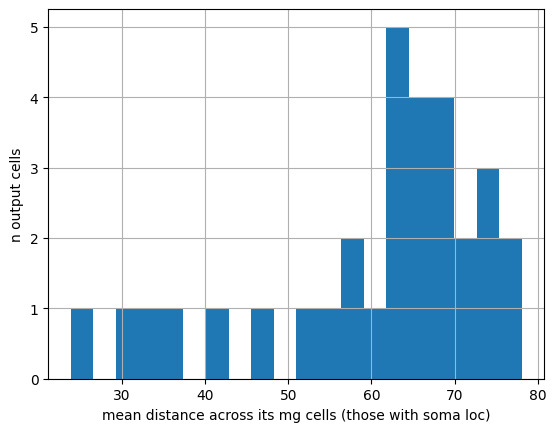

In [314]:
ax = result_df['distance_mean'].hist(bins=20)

ax.set_xlabel('mean distance across its mg cells (those with soma loc)')
ax.set_ylabel('n output cells')

# cluster map

In [418]:
types_ =  ['mli']#df_edges['pre_type'].unique() # ['mg1','mg2','lg','lf','sg1','sg2','sgx1','sgx2','grc-d','grc-s','aff','dml']#
df_map = pd.DataFrame()
for t in types_:
    df_grouped = df_edges[df_edges['pre_type']==t].groupby(
        ['pre','pre_type','post_type']).sum(numeric_only=True).reset_index().pivot(
        index='pre', columns='post_type', values='weight').fillna(0).reset_index()
    
    # df_grouped = df_edges[df_edges['pre_type']==t].groupby(
    #     ['pre','pre_type','post_type']).count().reset_index().pivot(
    #     index='pre', columns='post_type', values='post').fillna(0).reset_index()
    
    df_grouped['pre_type']=t
    df_map = pd.concat([df_map,df_grouped])
    

    
df_map = df_map.fillna(0)

df_map = df_map.set_index('pre')

In [419]:
tmp_type = pd.DataFrame(df_map['pre_type'])

In [420]:
df_map = df_map.drop(['pre_type'],axis=1)

# data_df = df_map[df_edges['post_type'].unique()].div(df_map[df_edges['post_type'].unique()].sum(axis=1),axis=0).mul(100).round(0)
data_df = df_map.div(df_map.sum(axis=1),axis=0).mul(100).round(0)
# data_df.loc[:,'pre_type']=tmp_type

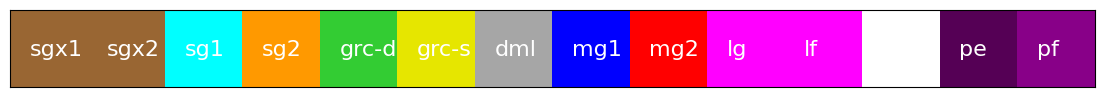

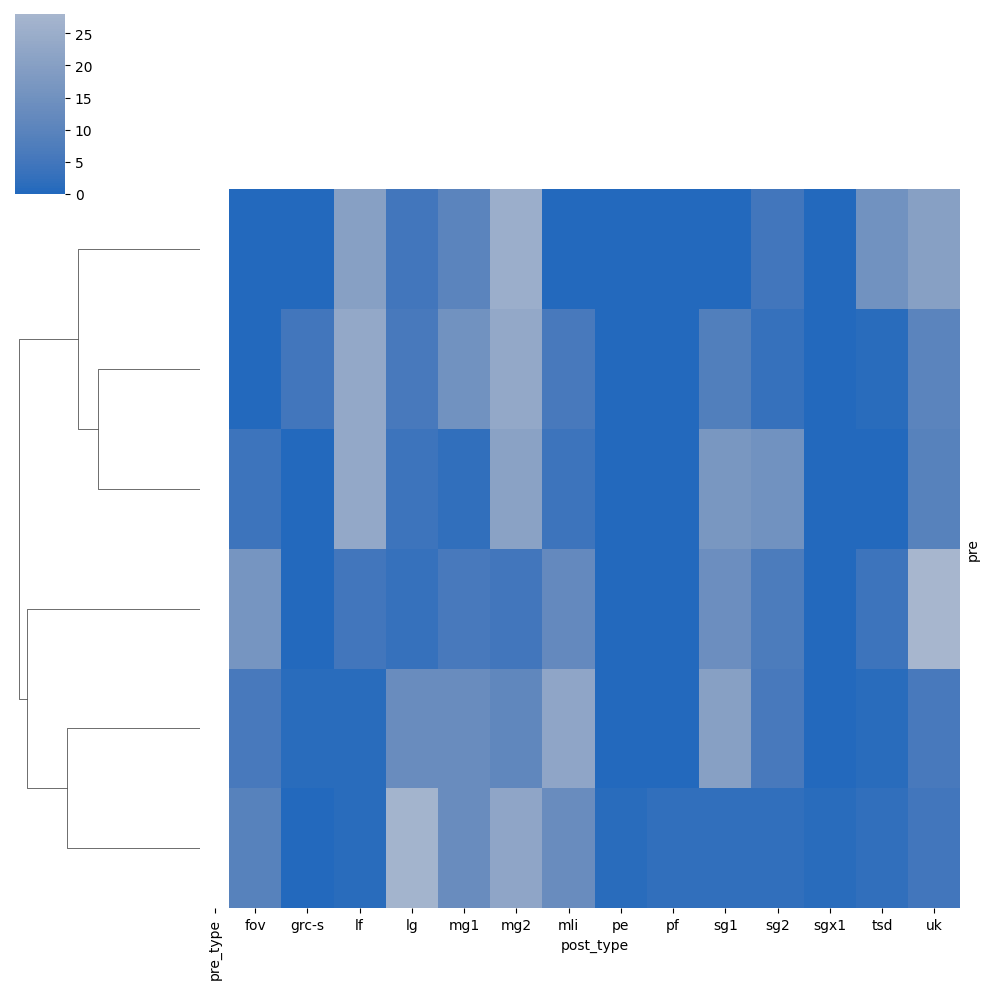

In [421]:
labels = tmp_type['pre_type'].unique()#df_map['pre_type'].unique()
color_pal = sns.color_palette("deep", len(labels))

color_dict = {
    'sgx1':'#996633',
    'sgx2':'#996633',
    'sg1':'#00ffff',
    'sg2':'#ff9900',
    'grc-d':'#33cc33',
    'grc-s':'#e6e600',
    'dml':'#a6a6a6',
    'mg1':'#0000ff',
    'mg2':'#ff0000',
    'lg':'#ff00ff',
    'lf':'#ff00ff',
    'aff':'#ffffff',
    'pe':'#550055',
    'pf':'#880088'
}
sns.palplot(color_dict.values())
ax = plt.gca()
ax.tick_params(left=False, bottom=False)

for i,v in enumerate(color_dict):
    ax.text(i-0.25, 0.1, v,fontsize=16,color='white') 


sns.clustermap(data = data_df,
               method='average',
               col_cluster=False, cmap="vlag", center=50,yticklabels=False,
               row_colors = tmp_type['pre_type'].map(color_dict));

# sns.clustermap(data = data_df,
#                method='average',
#                col_cluster=False, cmap="YlGnBu", yticklabels=False,
#                row_colors = tmp_type['pre_type'].map(color_dict));

# data_df = df_map[df_edges['post_type'].unique()]
# cmap = sns.color_palette("blend:#d9d9d9,#000000", as_cmap=True)
# cmap.set_under('white')
# sns.clustermap(data = data_df,
#                method='average',
#                col_cluster=False, cmap=cmap, vmin=1, yticklabels=False,
#                row_colors = df_map['pre_type'].map(color_dict));


# The methods are single, complete, average, weighted, ward, median, centroid
# from https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage
# default for seaborn is "average"

# CDF

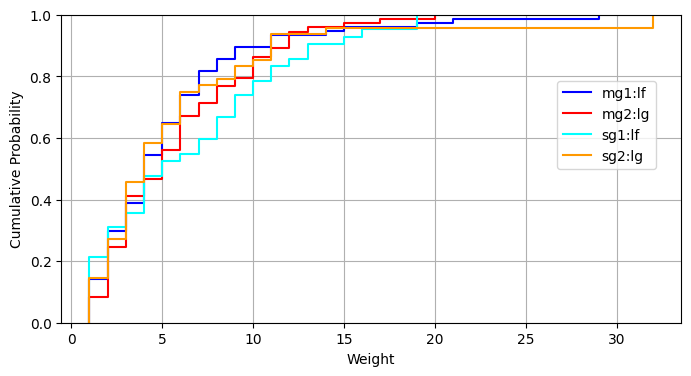

In [227]:
unique_connections = df_edges.groupby(['pre_type', 'post_type'])

hfig,ax = plt.subplots(1,figsize=(8, 4))
# hfig.set_title(f'Cumulative Distribution Plot for {pre_type}:{post_type} Connection')
for (pre_type, post_type), group_df in unique_connections:
    if (pre_type in ['mg1','sg1']) & (post_type in ['lf']):
        sns.ecdfplot(ax = ax,data=group_df, x='weight', stat='proportion',
                     label=f'{pre_type}:{post_type}', color=syn_colors[f'{pre_type}'])
    if (pre_type in ['mg2','sg2']) & (post_type in ['lg']):
        sns.ecdfplot(ax = ax,data=group_df, x='weight', stat='proportion',
                     label=f'{pre_type}:{post_type}', color=syn_colors[f'{pre_type}'])
ax.set_xlabel('Weight')
ax.set_ylabel('Cumulative Probability')
plt.legend(loc=(0.8,0.5))
plt.grid(True)
plt.show()

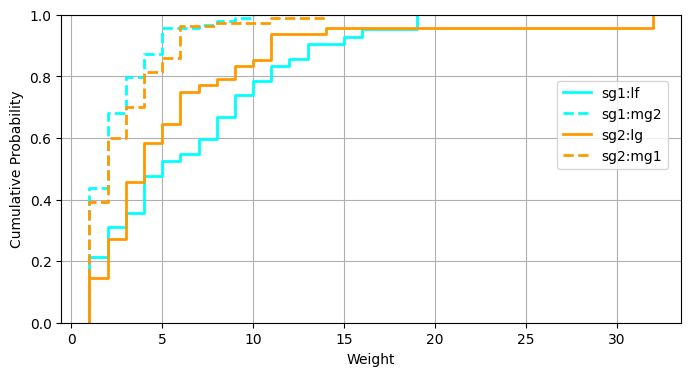

In [228]:
unique_connections = df_edges.groupby(['pre_type', 'post_type'])

hfig,ax = plt.subplots(1,figsize=(8, 4))
# hfig.set_title(f'Cumulative Distribution Plot for {pre_type}:{post_type} Connection')
for (pre_type, post_type), group_df in unique_connections:
    if (pre_type in ['sg1']) & (post_type in ['mg2']):
        sns.ecdfplot(ax = ax,data=group_df, x='weight', stat='proportion',
                     label=f'{pre_type}:{post_type}', color=syn_colors[f'{pre_type}'], linewidth=2, linestyle='--')
    if (pre_type in ['sg2']) & (post_type in ['mg1']):
        sns.ecdfplot(ax = ax,data=group_df, x='weight', stat='proportion',
                     label=f'{pre_type}:{post_type}', color=syn_colors[f'{pre_type}'], linewidth=2, linestyle='--')
    if (pre_type in ['sg1']) & (post_type in ['lf']):
        sns.ecdfplot(ax = ax,data=group_df, x='weight', stat='proportion',
                     label=f'{pre_type}:{post_type}', color=syn_colors[f'{pre_type}'], linewidth=2)
    if (pre_type in ['sg2']) & (post_type in ['lg']):
        sns.ecdfplot(ax = ax,data=group_df, x='weight', stat='proportion',
                     label=f'{pre_type}:{post_type}', color=syn_colors[f'{pre_type}'], linewidth=2)
    
ax.set_xlabel('Weight')
ax.set_ylabel('Cumulative Probability')
plt.legend(loc=(0.8,0.5))
plt.grid(True)
plt.show()

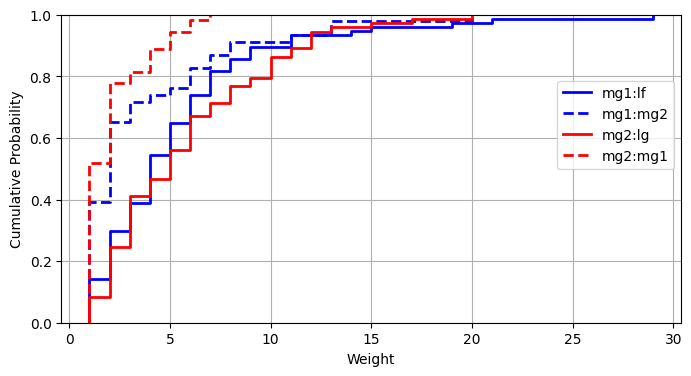

In [229]:
unique_connections = df_edges.groupby(['pre_type', 'post_type'])

hfig,ax = plt.subplots(1,figsize=(8, 4))
# hfig.set_title(f'Cumulative Distribution Plot for {pre_type}:{post_type} Connection')
for (pre_type, post_type), group_df in unique_connections:
    if (pre_type in ['mg1']) & (post_type in ['mg2']):
        sns.ecdfplot(ax = ax,data=group_df, x='weight', stat='proportion',
                     label=f'{pre_type}:{post_type}', color=syn_colors[f'{pre_type}'], linewidth=2, linestyle='--')
    if (pre_type in ['mg2']) & (post_type in ['mg1']):
        sns.ecdfplot(ax = ax,data=group_df, x='weight', stat='proportion',
                     label=f'{pre_type}:{post_type}', color=syn_colors[f'{pre_type}'], linewidth=2, linestyle='--')
    if (pre_type in ['mg1']) & (post_type in ['lf']):
        sns.ecdfplot(ax = ax,data=group_df, x='weight', stat='proportion',
                     label=f'{pre_type}:{post_type}', color=syn_colors[f'{pre_type}'], linewidth=2)
    if (pre_type in ['mg2']) & (post_type in ['lg']):
        sns.ecdfplot(ax = ax,data=group_df, x='weight', stat='proportion',
                     label=f'{pre_type}:{post_type}', color=syn_colors[f'{pre_type}'], linewidth=2)
    
ax.set_xlabel('Weight')
ax.set_ylabel('Cumulative Probability')
plt.legend(loc=(0.8,0.5))
plt.grid(True)
plt.show()

# Distribution of weights by type

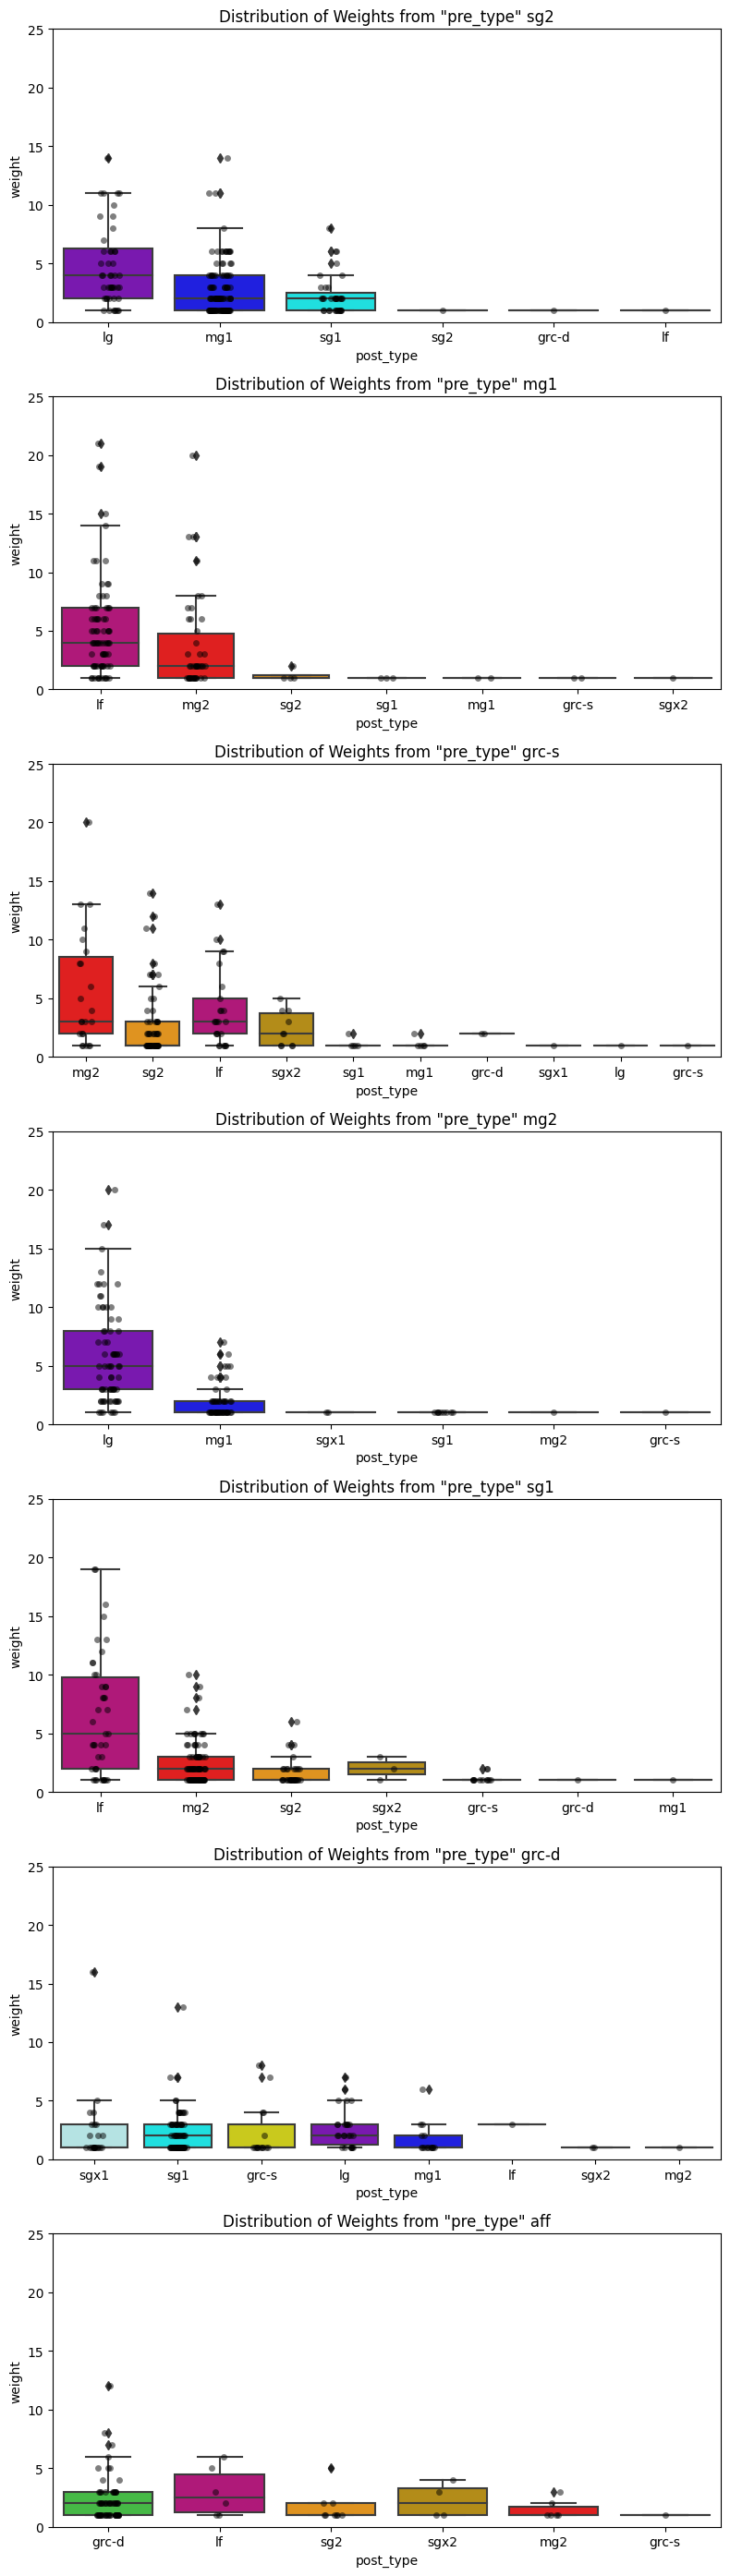

In [1833]:
# df= df_edges[(df_edges['pre_type'].isin(['sg1','sg2','mg1','mg2'])) & (df_edges['post_type'].isin(['mg1','mg2','lf','lg']))]

fig, axes = plt.subplots(len(df_edges['pre_type'].unique()), 1, figsize=(8, 4 * len(df_edges['pre_type'].unique())))

for i,p in enumerate(df_edges['pre_type'].unique()):

    sns.boxplot(data=df_edges[df_edges['pre_type'] == p], x='post_type', y='weight', ax=axes[i],palette=syn_colors)#, inner='quartile', palette='Set2')
    sns.stripplot(data=df_edges[df_edges['pre_type'] == p], x='post_type', y='weight', ax=axes[i],color='black',alpha=0.5)
    axes[i].set_title(f'Distribution of Weights from "pre_type" {p}')
    axes[i].set_ylim(0,25)

plt.tight_layout()
plt.show()